## Import Libraries

In [10]:
import os
import numpy as np
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from copy import deepcopy
RESULTS_DIR = '/data/results/MSTD'
DATASET_DIR = '/data/datasets'

## Eval Utils

In [11]:
def compute_precision_recall_etc(loop_data, plgt_data, score_thres):
    """ >>> Compute precision & Recall """    
    SKIP_NUM = 50
    ARG_LOOP_THRES = 20.0
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    N_DATA = loop_data.shape[0]

    if N_DATA <= SKIP_NUM:
        print(f"[WARN] dataset length({N_DATA}) is smaller than skip length({SKIP_NUM})")
        exit(0)


    
    for i in range(SKIP_NUM, N_DATA):
        score = loop_data[i,1]
        
        
        t_sec = loop_data[i,0]
        score = loop_data[i,1]
        t_query = loop_data[i,2:5].reshape((3,1))
        t_dbase = loop_data[i,5:8].reshape((3,1))
        
        dist = np.linalg.norm(t_query - t_dbase)
        
        # loop_candidates = loop_data[0:i-SKIP_NUM+1,2:5]
        # loop_candidates_dist:np.ndarray = loop_candidates - np.tile(t_query.reshape((1,3)), (loop_candidates.shape[0],1))
        # loop_candidates_dist = np.linalg.norm(loop_candidates_dist, axis=1)
        # min_dist = 9999.0
        # # print("loop_candidates_dist: ", loop_candidates_dist.shape)
        # # print(loop_candidates_dist.tolist())
        # if (loop_candidates_dist <= ARG_LOOP_THRES).any():
        #     # print(f"Loop exists")
        #     # is_loop = True
        #     min_dist = loop_candidates_dist.min()
        
        # is_loop = is_in_part(t_sec, part_data)
        
        if score >= score_thres:
            if plgt_data[i] or dist <= ARG_LOOP_THRES:
                true_positive  += 1
            else:
                false_positive += 1
        else:
            if plgt_data[i]:
                false_negative += 1
            else:
                true_negative  += 1
    
    etc = [ true_positive, false_positive,
            true_negative, false_negative ]
    if true_positive == 0:
        return 0.0, 0.0, etc
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    return precision, recall, etc

In [12]:
def parse_pseudo_loop_gt(src_dir:Path, exid:str, threshold:float, use_union_div):
    data_fn = src_dir / exid / 'pseudo_loop_gt.txt'
    data = np.genfromtxt(data_fn, delimiter=',') 
    if use_union_div:
        data = data[:,1] >= threshold
        return data
    else:
        data = data[:,0] >= threshold
        return data
################ Test ##################
do_test = True
if do_test:
    plgt_exids = [ 
        'park_avia_01_vvt=1',
        'park_avia_01_vvt=3',
        'park_avia_01_vvt=5',
        'park_avia_01_vvt=10',
        'park_avia_02_vvt=1',
        'park_avia_02_vvt=3',
        'park_avia_02_vvt=5',
        'park_avia_02_vvt=10']
    for plgt_exid in plgt_exids:
        plgt_data = parse_pseudo_loop_gt(
            Path('/data/results/MSTD/230926_pseudo_loop_gt_detection/'),
            plgt_exid, 0.55, False)
        print(f"{plgt_exid}: {plgt_data.shape[0]} | sum:{plgt_data.sum()}")
########################################
def get_plgt_data(seq_id:str):
    """ 실험 결과를 지켜보았을 때, Overlapped ratio 0.55, Not Use Union division이 결과를 보기에 더 좋을 것 같다. """
    assert(seq_id == '01' or seq_id == '02')
    return parse_pseudo_loop_gt(
        Path('/data/results/MSTD/230926_pseudo_loop_gt_detection/'),
        f'park_avia_{seq_id}_vvt=5', 0.6, False)

park_avia_01_vvt=1: 598 | sum:149
park_avia_01_vvt=3: 598 | sum:155
park_avia_01_vvt=5: 598 | sum:158
park_avia_01_vvt=10: 598 | sum:158
park_avia_02_vvt=1: 539 | sum:232
park_avia_02_vvt=3: 539 | sum:232
park_avia_02_vvt=5: 539 | sum:232
park_avia_02_vvt=10: 539 | sum:233


In [13]:
def z_align(pose_data):
    N = pose_data.shape[0]
    xyz = pose_data[:,1:4]
    # print(f"xys.shape: {xyz.shape}")
    pca = PCA(n_components=3)
    pca.fit(xyz)
    # print(pca.explained_variance_ratio_.shape)
    # print(pca.components_.shape, type(pca.components_))
    R = pca.components_
    # print(np.dot(R, R.T))
    # print("Align R.T:\n", R.T)
    new_xyz = np.dot(xyz, R.T)
    pca2 = PCA(n_components=3)
    pca2.fit(new_xyz)
    # print(pca2.components_)
    # print(pca2.explained_variance_)
    return new_xyz

In [14]:
def get_normed_timestamps(pose_data):
    start = pose_data[0,0]
    end = pose_data[-1,0]
    timestamps = (pose_data[:,0] - start) / (end - start)
    return timestamps
  
def plot_traj_and_loop(raw_pose_data, loop_data, seq='01'):
    print("Before aligned | x_min:%.2f x_max:%.2f" % (raw_pose_data[:,1].min(), raw_pose_data[:,1].max()))
    print("Before aligned | y_min:%.2f y_max:%.2f" % (raw_pose_data[:,2].min(), raw_pose_data[:,2].max()))
    print("Before aligned | z_min:%.2f z_max:%.2f" % (raw_pose_data[:,3].min(), raw_pose_data[:,3].max()))
    pose_data = deepcopy(raw_pose_data)
    pose_data[:,1:4] = z_align(raw_pose_data)
    normed_time = get_normed_timestamps(pose_data)
    colors_01 = plt.cm.viridis(normed_time)
    print("After  aligned | x_min:%.2f x_max:%.2f" % (pose_data[:,1].min(), pose_data[:,1].max()))
    print("After  aligned | y_min:%.2f y_max:%.2f" % (pose_data[:,2].min(), pose_data[:,2].max()))
    print("After  aligned | z_min:%.2f z_max:%.2f" % (pose_data[:,3].min(), pose_data[:,3].max()))

    # 2D plot 생성
    fig, ax = plt.subplots(figsize=(16, 5))
    for i in range(normed_time.shape[0] - 1):
        # 현재 시간과 다음 시간 사이의 데이터를 이용하여 선을 그림
        line = Line2D([pose_data[i,1], pose_data[i+1,1]], [pose_data[i,2], pose_data[i+1,2]], color=colors_01[i])
        ax.add_line(line)
    
    keyframes_xs = []
    keyframes_ys = []
    for i in range(1, normed_time.shape[0]):
        if i % 10 != 0:
            continue
        
        idx = (i // 10) - 1
        if loop_data[idx,0] >= 0.6:
            keyframes_xs.append(pose_data[i,1])
            keyframes_ys.append(pose_data[i,2])

    keyframes_xs = np.array(keyframes_xs, dtype=float)
    keyframes_ys = np.array(keyframes_ys, dtype=float)
    
    # 시각화 설정
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Park Avia {seq} Dataset 2D Trajectory Plot')
    ax.set_xlim(pose_data[:,1].min(), pose_data[:,1].max())
    ax.set_ylim(pose_data[:,2].min(), pose_data[:,2].max())
    ax.scatter(keyframes_xs, keyframes_ys, label='Loop Pose', color='r', marker='X')

    # 색상 막대 표시
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Time')

    # 플롯 출력
    # plt.show()
    fig.tight_layout()
    plt.savefig('test.png', dpi=300)

In [15]:
def plot_trajectory_with_result(raw_pose_data, loop_data, plgt_data, score_thres, seq_id:str='01'):
    pose_data = deepcopy(raw_pose_data)
    pose_data[:,1:4] = z_align(raw_pose_data)
    normed_time = get_normed_timestamps(pose_data)
    colors_01 = plt.cm.viridis(normed_time)
    SKIP_NUM = 50
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    # 2D plot 생성
    fig, ax = plt.subplots(figsize=(16, 5))
    for i in range(normed_time.shape[0] - 1):
        # 현재 시간과 다음 시간 사이의 데이터를 이용하여 선을 그림
        line = Line2D([pose_data[i,1], pose_data[i+1,1]], [pose_data[i,2], pose_data[i+1,2]], color=colors_01[i])
        ax.add_line(line)
    
    keyframes_xs = []
    keyframes_ys = []
    for i in range(1, normed_time.shape[0]):
        if i % 10 != 0:
            continue
        
        idx = (i // 10) - 1
        if loop_data[idx,0] >= 0.6:
            keyframes_xs.append(pose_data[i,1])
            keyframes_ys.append(pose_data[i,2])

    keyframes_xs = np.array(keyframes_xs, dtype=float)
    keyframes_ys = np.array(keyframes_ys, dtype=float)
    
    assert(keyframes_xs.shape[0] == loop_data.shape[0])
    assert(keyframes_ys.shape[0] == loop_data.shape[0])
    TP_xs = []; TP_ys = []
    TN_xs = []; TN_ys = []
    FP_xs = []; FP_ys = []
    FN_xs = []; FN_ys = []
    
    for i in range(SKIP_NUM, loop_data.shape[0]):
        score = loop_data[i,1]
        
        if score >= score_thres:
            if plgt_data[i]:
                true_positive  += 1
                TP_xs.append(keyframes_xs[i])
                TP_ys.append(keyframes_ys[i])
            else:
                false_positive += 1
                FP_xs.append(keyframes_xs[i])
                FP_ys.append(keyframes_ys[i])
        else:
            if plgt_data[i]:
                false_negative += 1
                FN_xs.append(keyframes_xs[i])
                FN_ys.append(keyframes_ys[i])
            else:
                true_negative  += 1
                TN_xs.append(keyframes_xs[i])
                TN_ys.append(keyframes_ys[i])
    TP_xs = np.array(TP_xs, dtype=float)
    TP_ys = np.array(TP_ys, dtype=float)
    TN_xs = np.array(TN_xs, dtype=float)
    TN_ys = np.array(TN_ys, dtype=float)
    FP_xs = np.array(FP_xs, dtype=float)
    FP_ys = np.array(FP_ys, dtype=float)
    FN_xs = np.array(FN_xs, dtype=float)
    FN_ys = np.array(FN_ys, dtype=float)
    # print(f"true_positive: {true_positive}")
    # print(f"false_positive: {false_positive}")
    # print(f"false_negative: {false_negative}")
    # print(f"true_negative: {true_negative}")
        
    # 시각화 설정
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(r'2D Trajectory Plot with result ($\theta_{icp}$ := %.2f)' % score_thres)
    ax.set_xlim(pose_data[:,1].min(), pose_data[:,1].max())
    ax.set_ylim(pose_data[:,2].min(), pose_data[:,2].max())
    if true_positive > 0:
        ax.scatter(TP_xs, TP_ys, label='True Positive', color='b', marker='o', facecolors='none')
    if false_negative > 0:
        ax.scatter(FN_xs, FN_ys, label='False Negative', color='r', marker='^', facecolors='none')
    if false_positive > 0:
        ax.scatter(FP_xs, FP_ys, label='False Positive', color='r', marker='x')

    # 색상 막대 표시
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Time')

    # 플롯 출력
    # plt.show()
    plt.savefig(f'result_any_{seq_id}/score_thres={score_thres:.2f}.png', dpi=300)

## Evaluation

### 231003 Precision-Recall graphs according to z_max limitation

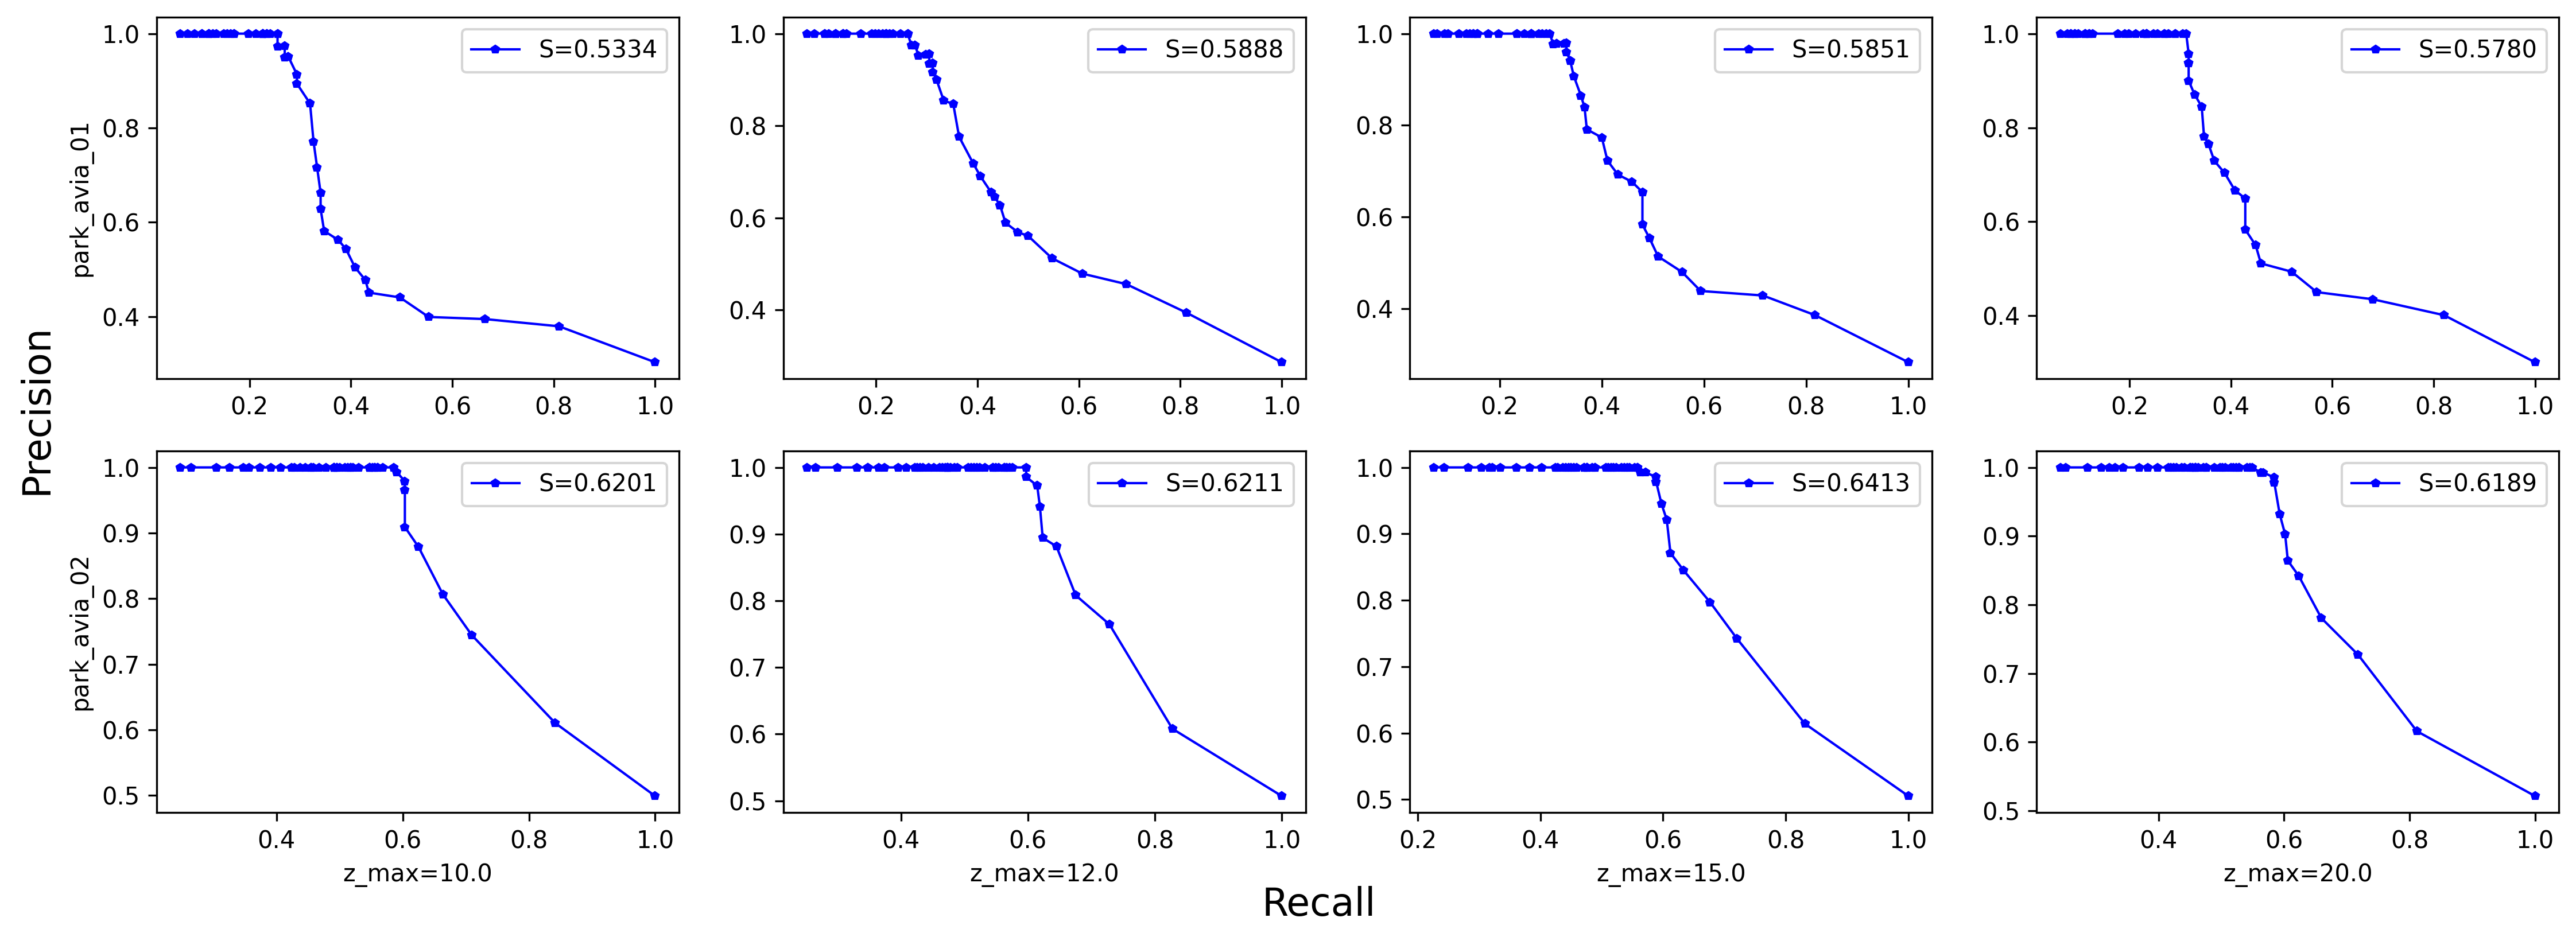

In [16]:
seq_name = 'park_avia'
exid = '231003_except_trees'
plgt_dir = Path('/data/results/MSTD/230926_pseudo_loop_gt_detection/')
thres_arr = np.linspace(0.5, 0.0, num=51).tolist()

fig, axes = plt.subplots(2, 4, figsize=(18, 6), sharex=False, sharey=False,  dpi=300)
fig.text(0.5, 0.01, 'Recall', ha='center', fontsize=16.0)
fig.text(0.08, 0.5, 'Precision', va='center', fontsize=16.0, rotation='vertical')
axes[0][0].set_ylabel('park_avia_01')
axes[1][0].set_ylabel('park_avia_02')
axes[1][0].set_xlabel('z_max=10.0')
axes[1][1].set_xlabel('z_max=12.0')
axes[1][2].set_xlabel('z_max=15.0')
axes[1][3].set_xlabel('z_max=20.0')
for row, seq_id in enumerate(['01', '02']):
    for col, z_max in enumerate([10.0, 12.0, 15.0, 20.0]):
        loop_fn = f"{RESULTS_DIR}/{exid}/{seq_name}_{seq_id}-z_max={z_max:.1f}/result.csv"
        loop_data = np.genfromtxt(loop_fn, delimiter=',')
        plgt_data = get_plgt_data(seq_id)
          
        xs = []
        precisions = []
        recalls = []

        for i in range(len(thres_arr)):
            precision, recall, etc = compute_precision_recall_etc(loop_data, plgt_data, thres_arr[i])
            xs.append(thres_arr[i])
            precisions.append(precision)
            recalls.append(recall)
            

        xs = np.array(xs, dtype=float)
        precisions = np.array(precisions, dtype=float)
        recalls = np.array(recalls, dtype=float)
        area_sum = (((precisions[1:] + precisions[:-1])/2) * (recalls[1:] - recalls[:-1])).sum()
        
        
        # Plot data on the first subplot (top)
        axes[row][col].plot(recalls, precisions, label=f'S={area_sum:.4f}', color='b', marker='p', linewidth=1, markersize=3)
        # axes[0].set_title('Line Graph 1')
        axes[row][col].legend()

          
# Adjust the spacing between subplots
# plt.tight_layout()

# Show the plot
plt.show()

### 231003 When z_max=20.0, trajectory plot with result visualization

In [17]:
park_avia_01_pose = np.genfromtxt('/data/datasets/dataset_std/park_avia/park1_pose.txt')
park_avia_01_vvt5_loop = np.genfromtxt('/root/cw-eval-tools/eval_std/results_avia_park/std_park_avia_01_pseudo_loop_vvt5.csv', delimiter=',')
print(f'park_avia_01_pose shape: {park_avia_01_pose.shape}')
print(f'park_avia_01_vvt5_loop shape: {park_avia_01_vvt5_loop.shape}')
park_avia_02_pose = np.genfromtxt('/data/datasets/dataset_std/park_avia/park2_pose.txt')
park_avia_02_vvt5_loop = np.genfromtxt('/root/cw-eval-tools/eval_std/results_avia_park/std_park_avia_02_pseudo_loop_vvt5.csv', delimiter=',')
print(f'park_avia_02_pose shape: {park_avia_02_pose.shape}')
print(f'park_avia_02_vvt5_loop shape: {park_avia_02_vvt5_loop.shape}')

park_avia_01_pose shape: (5986, 8)
park_avia_01_vvt5_loop shape: (598, 2)
park_avia_02_pose shape: (5393, 8)
park_avia_02_vvt5_loop shape: (539, 2)


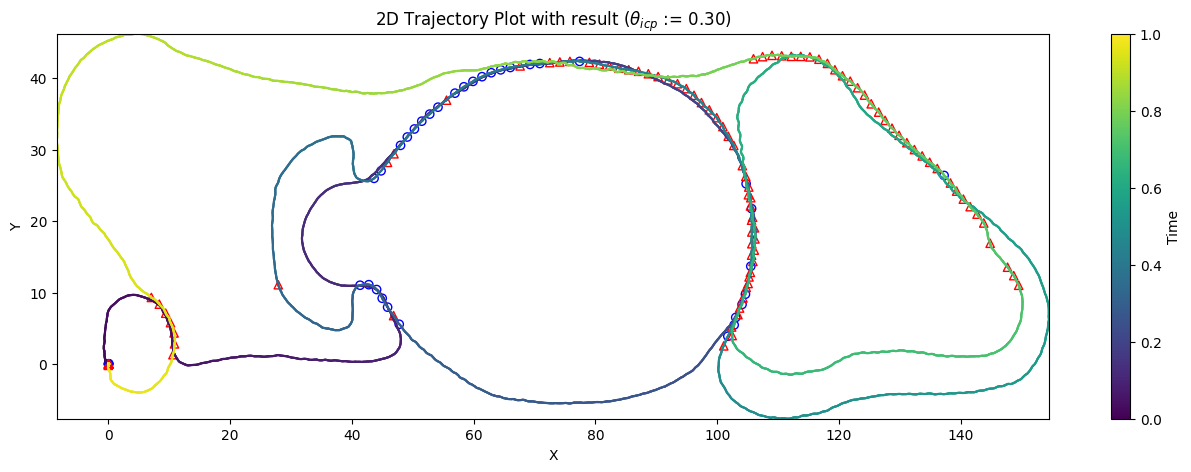

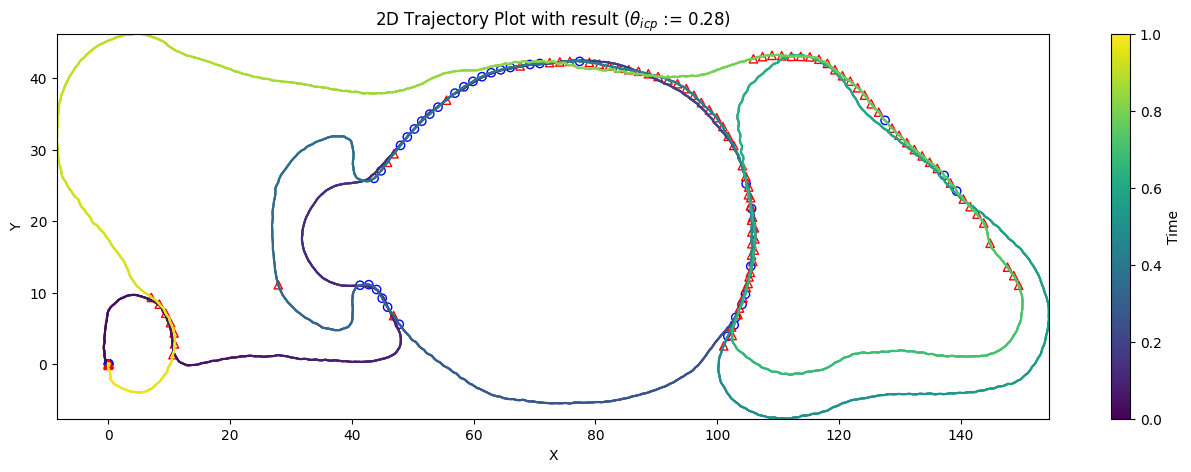

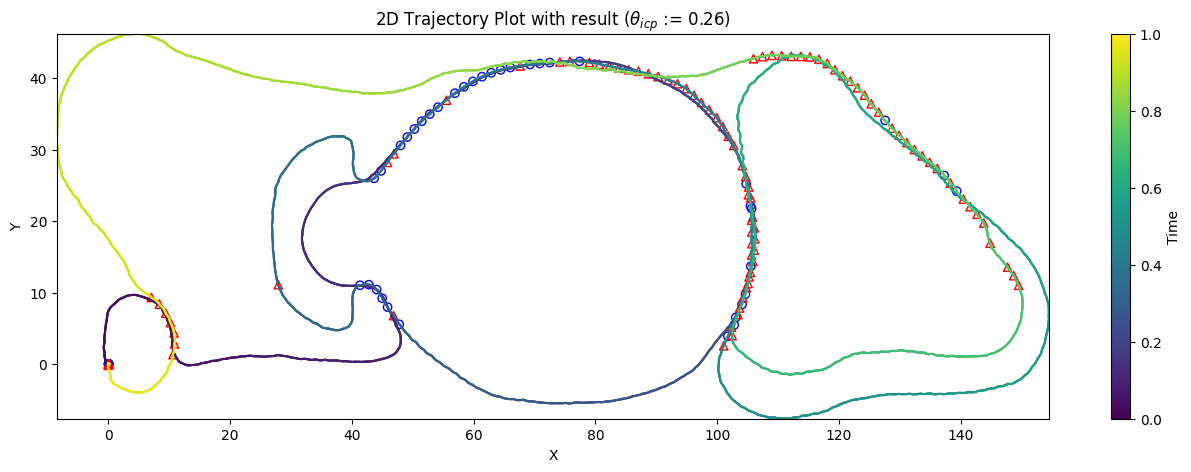

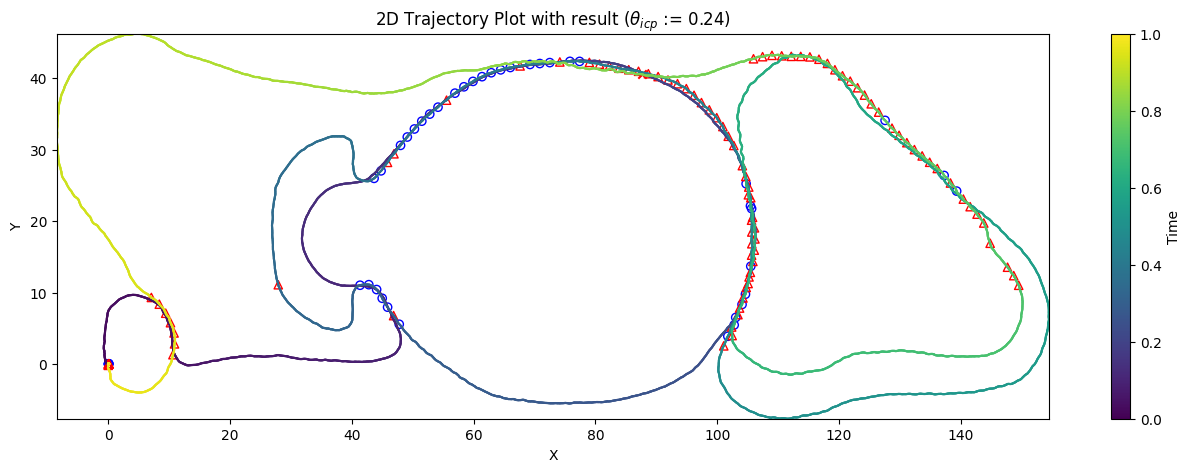

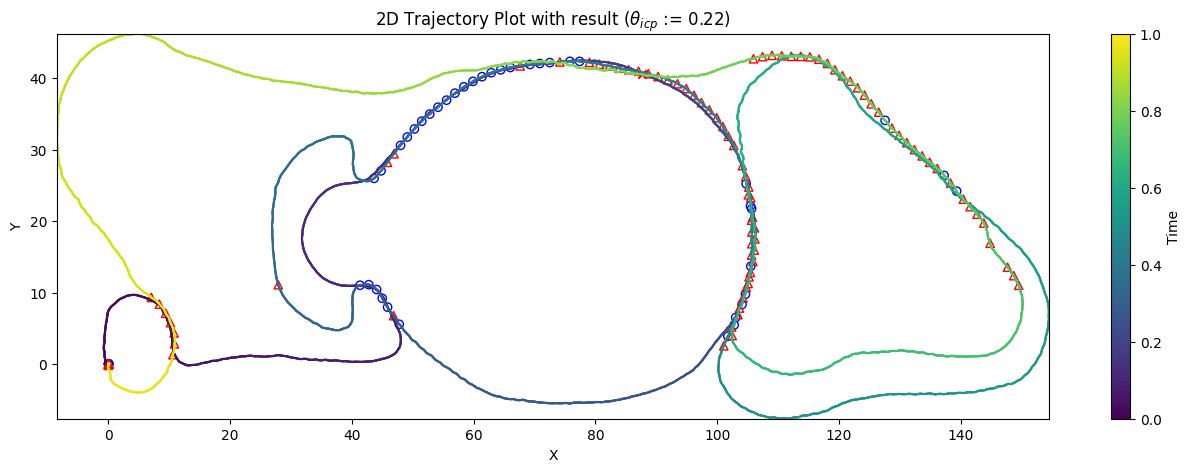

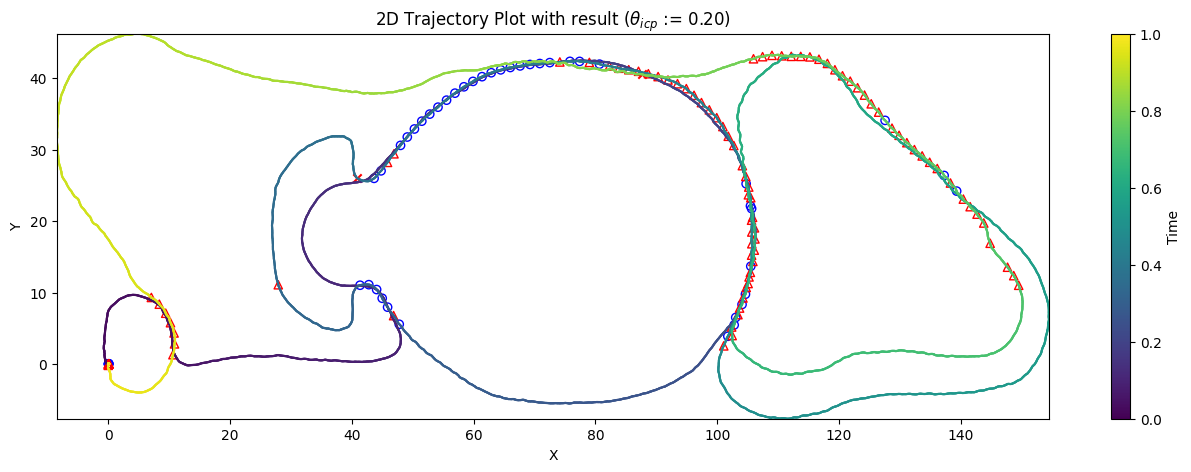

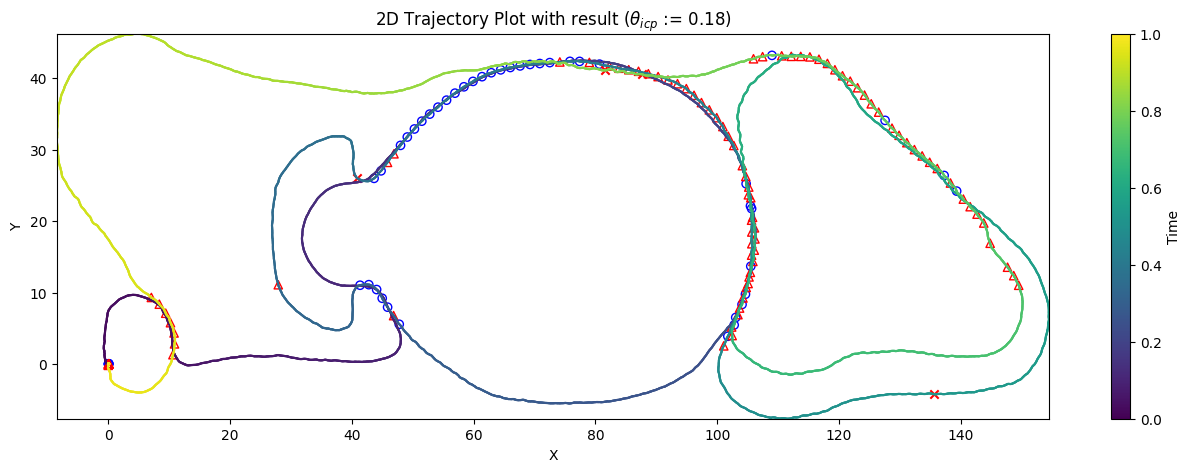

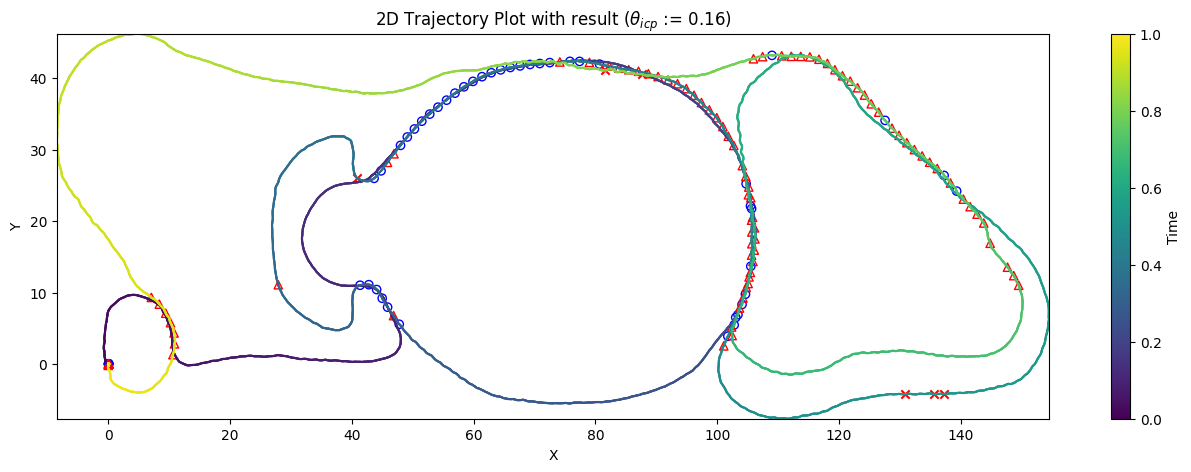

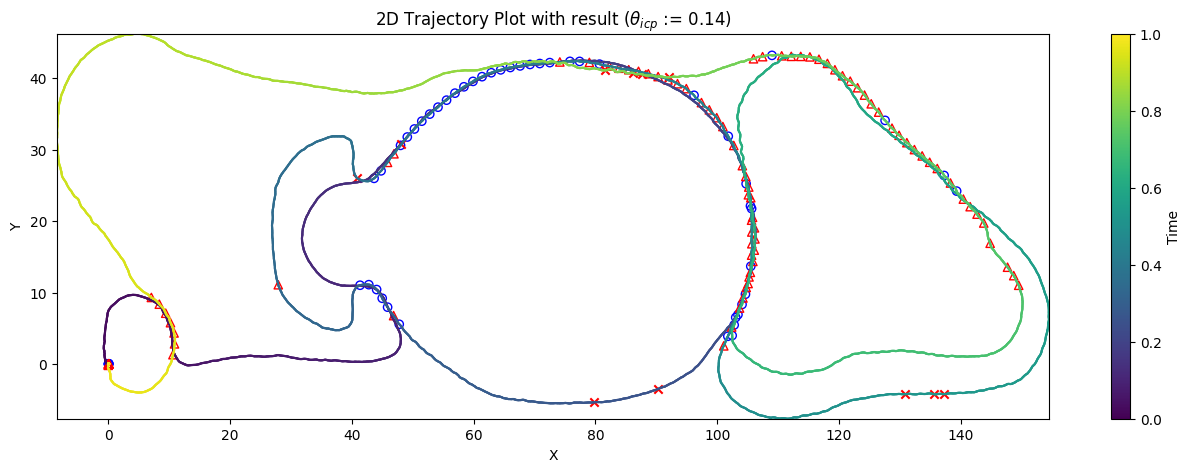

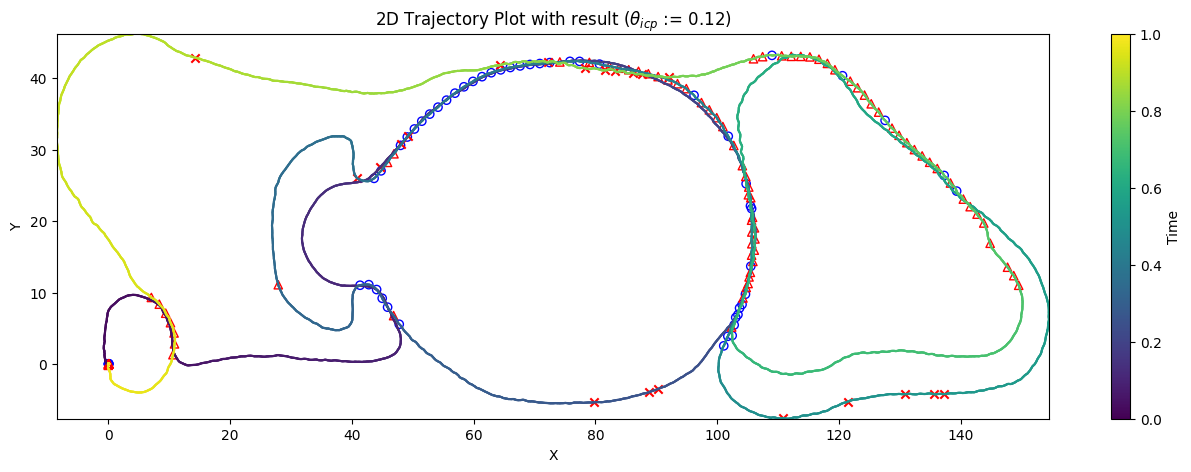

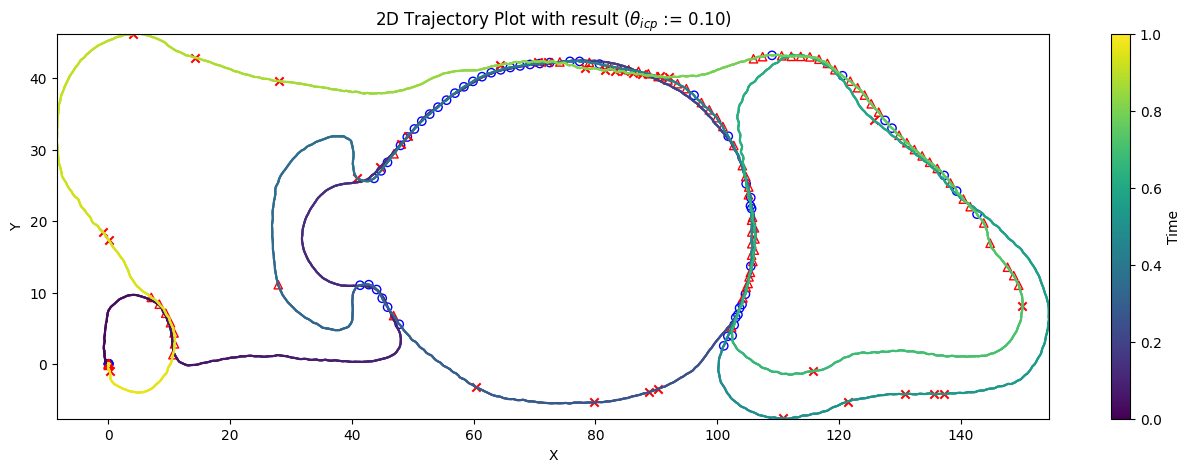

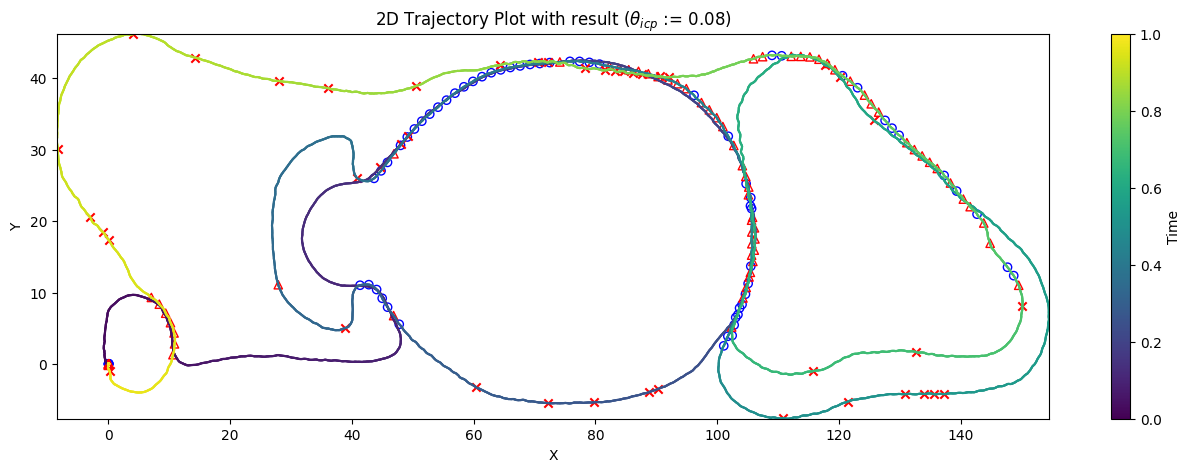

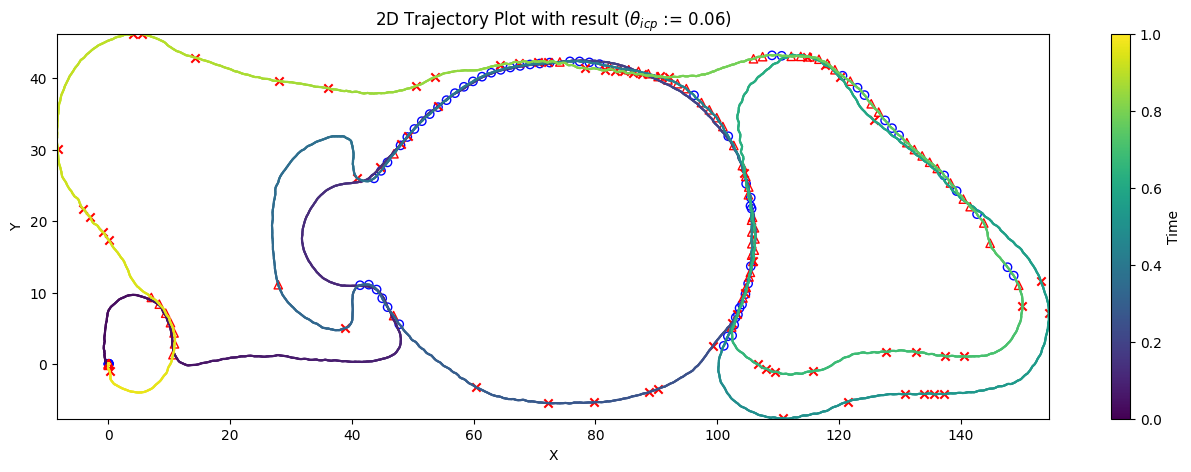

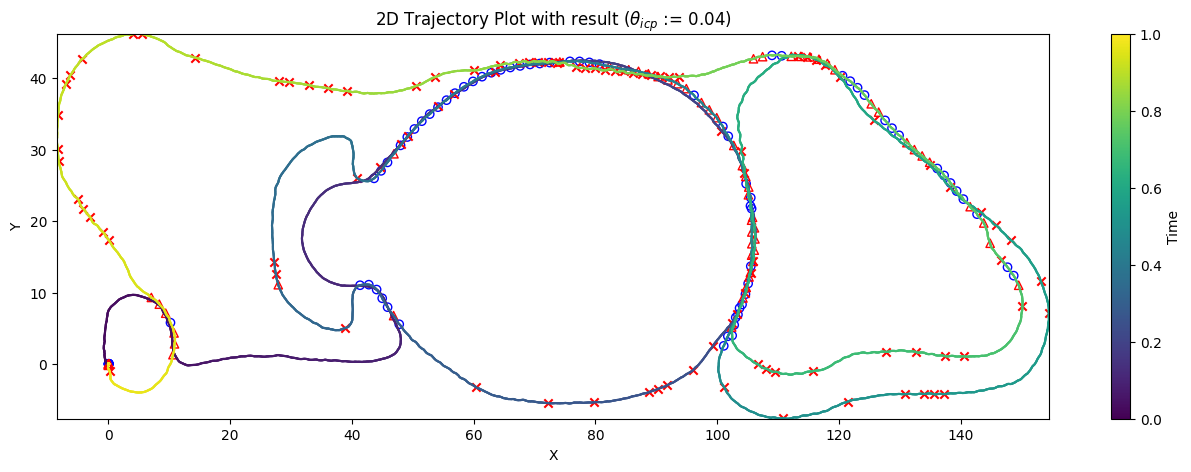

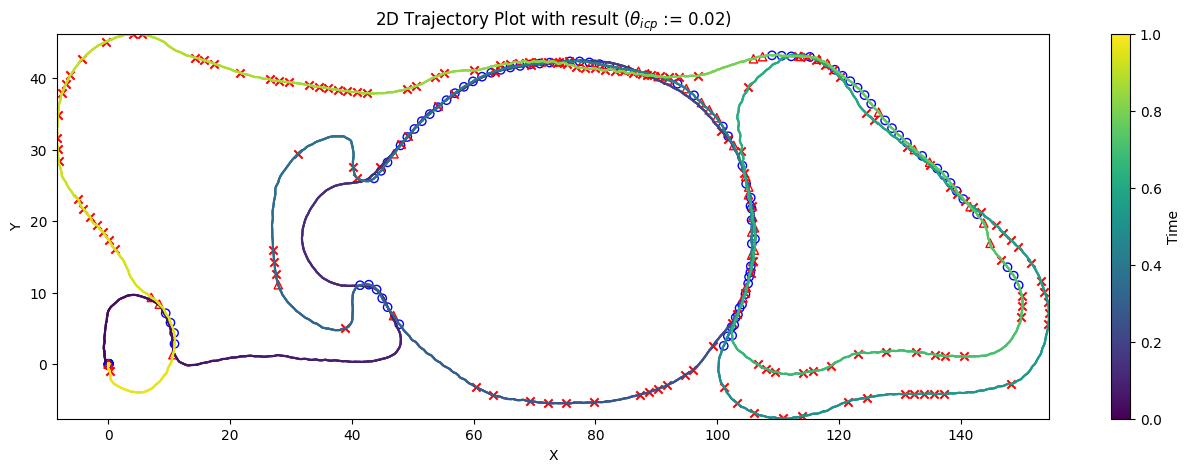

In [18]:
seq_name = 'park_avia'
exid = '231003_except_trees'
plgt_dir = Path('/data/results/MSTD/230926_pseudo_loop_gt_detection/')

loop_fn = f"{RESULTS_DIR}/{exid}/{seq_name}_01-z_max=15.0/result.csv"
loop_data = np.genfromtxt(loop_fn, delimiter=',')
plgt_data = get_plgt_data('01')

thres_arr = np.linspace(0.3, 0.0, num=16).tolist()
for score_thres in thres_arr[:-1]:
    plot_trajectory_with_result(park_avia_01_pose, loop_data, plgt_data, score_thres, '01')

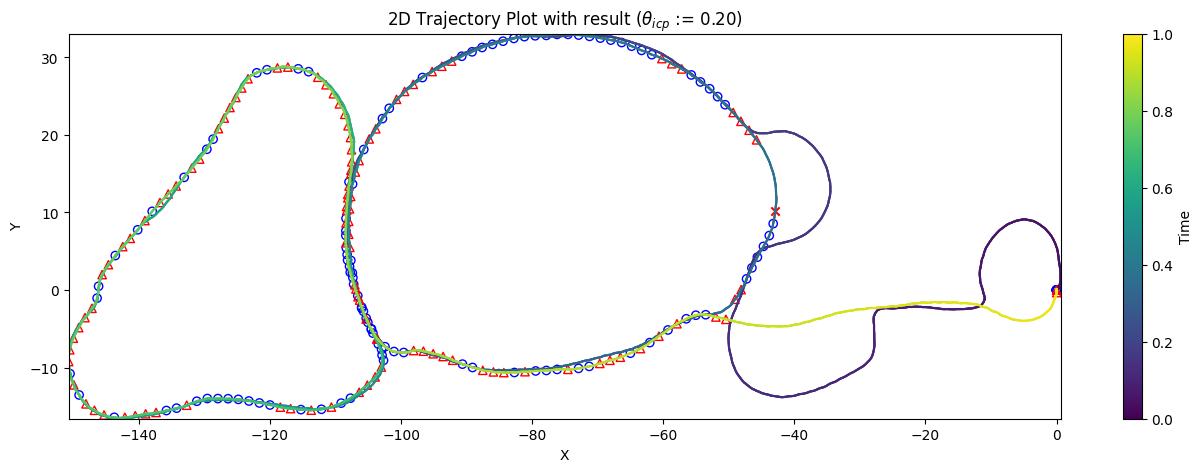

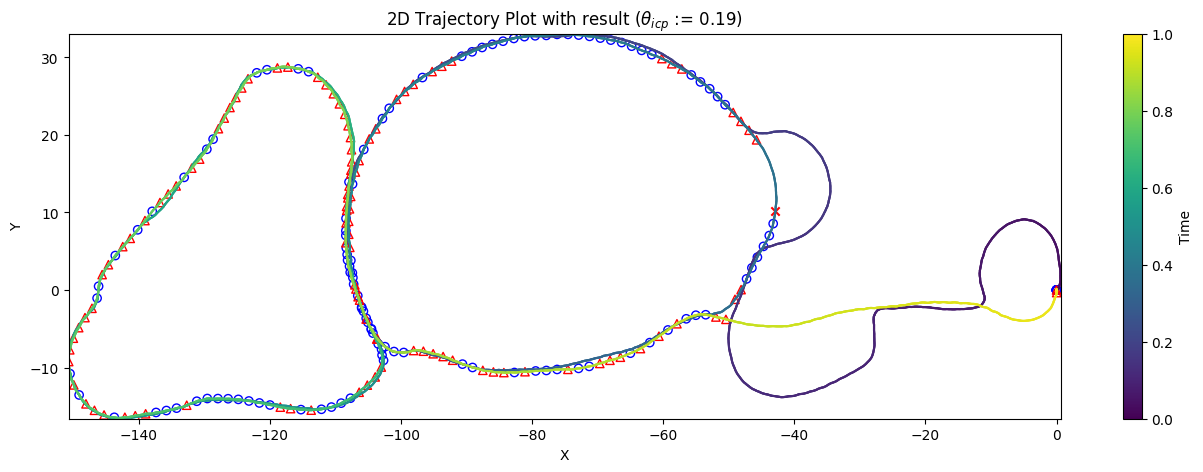

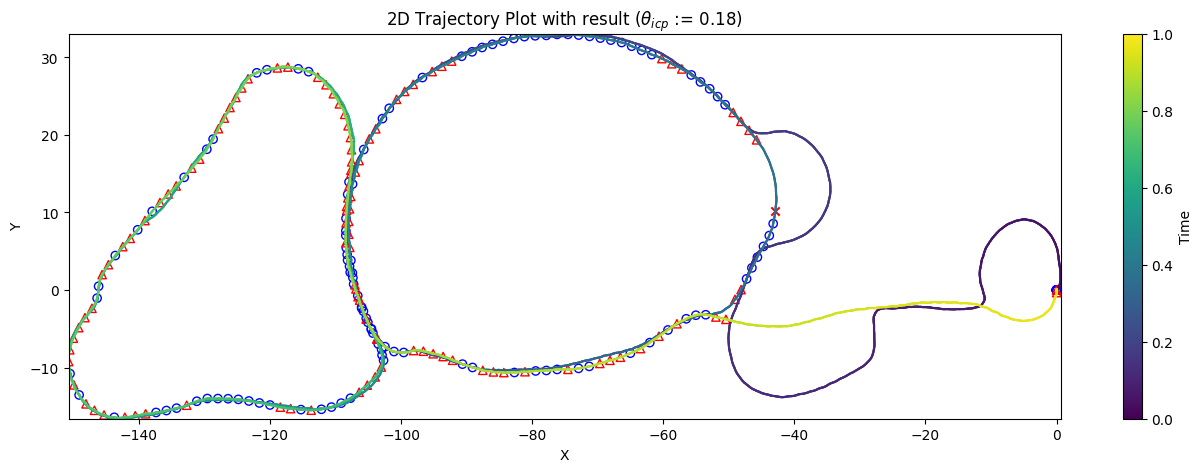

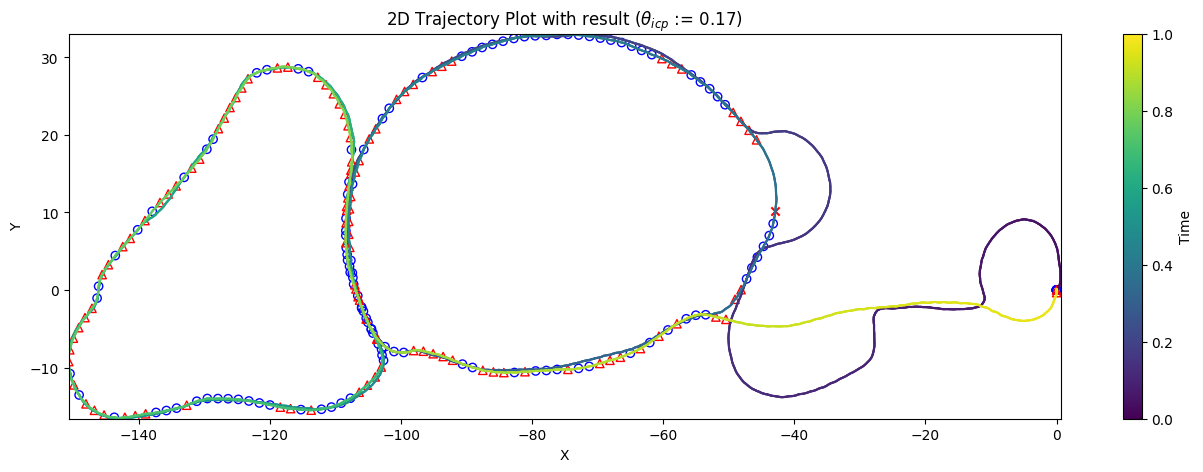

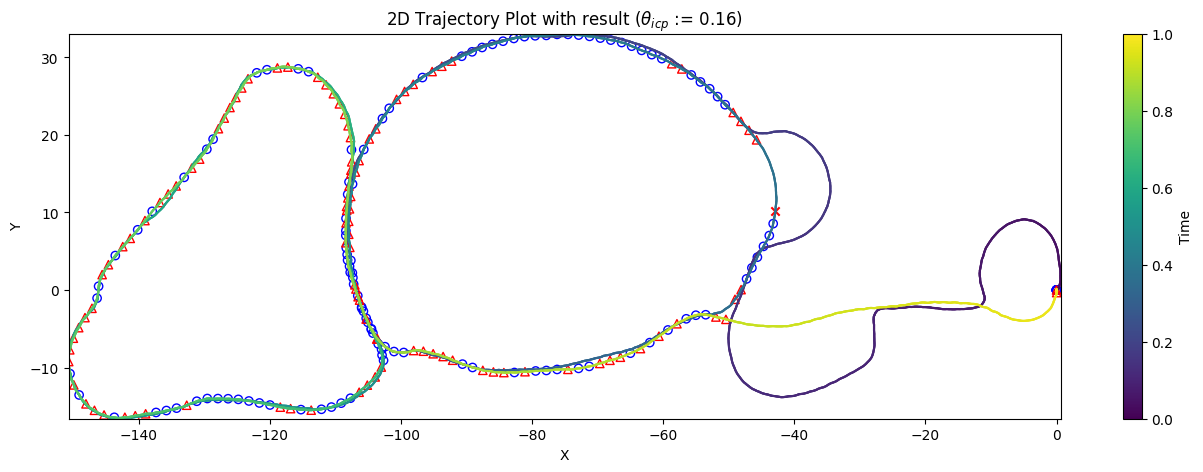

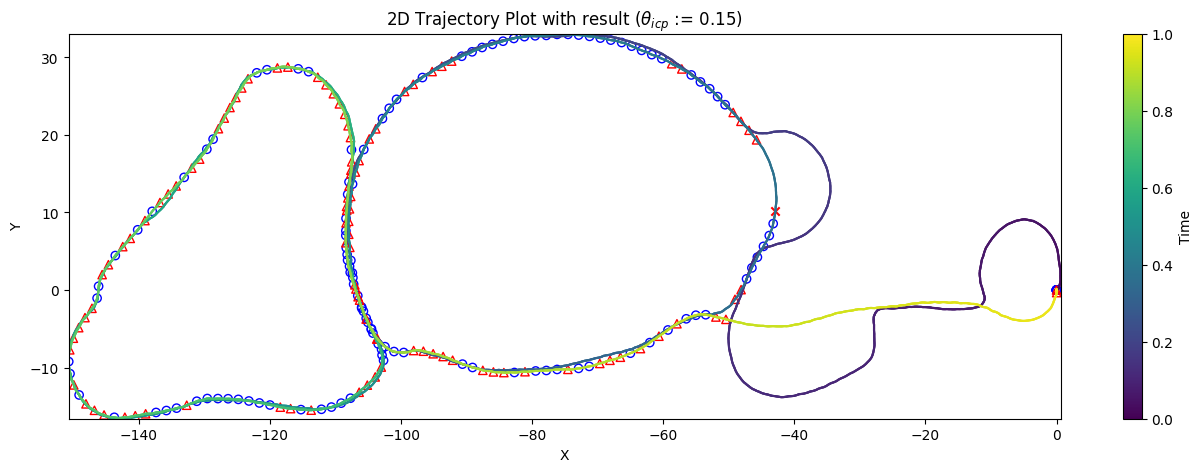

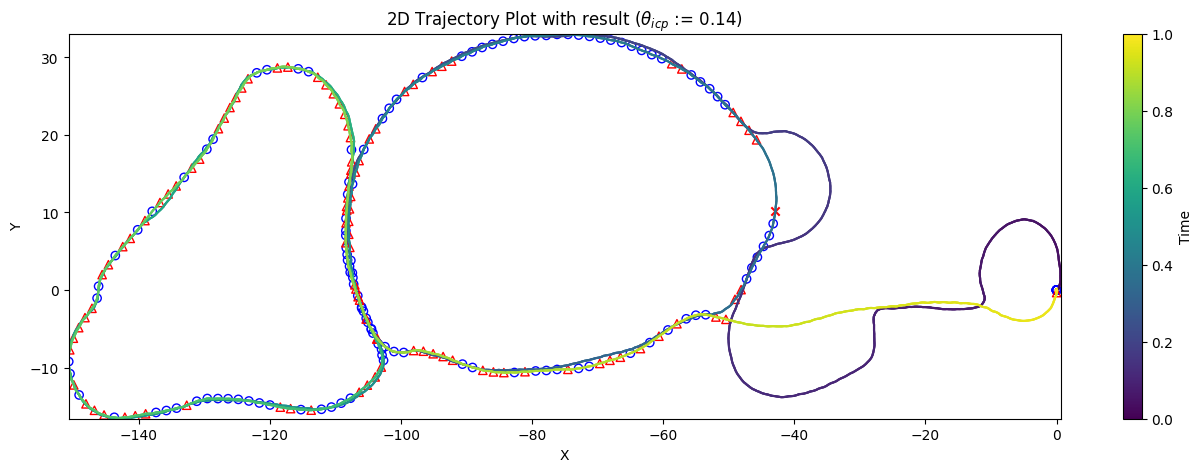

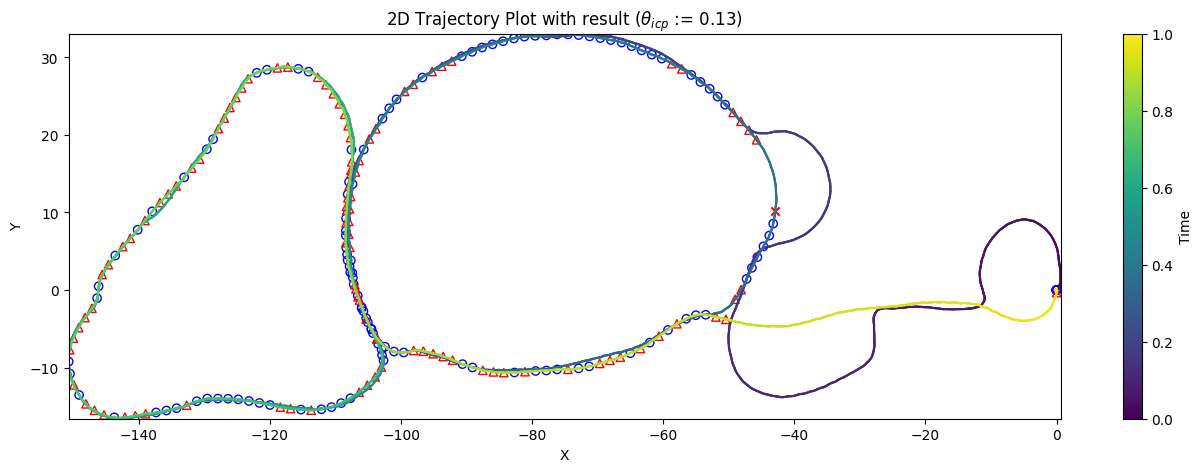

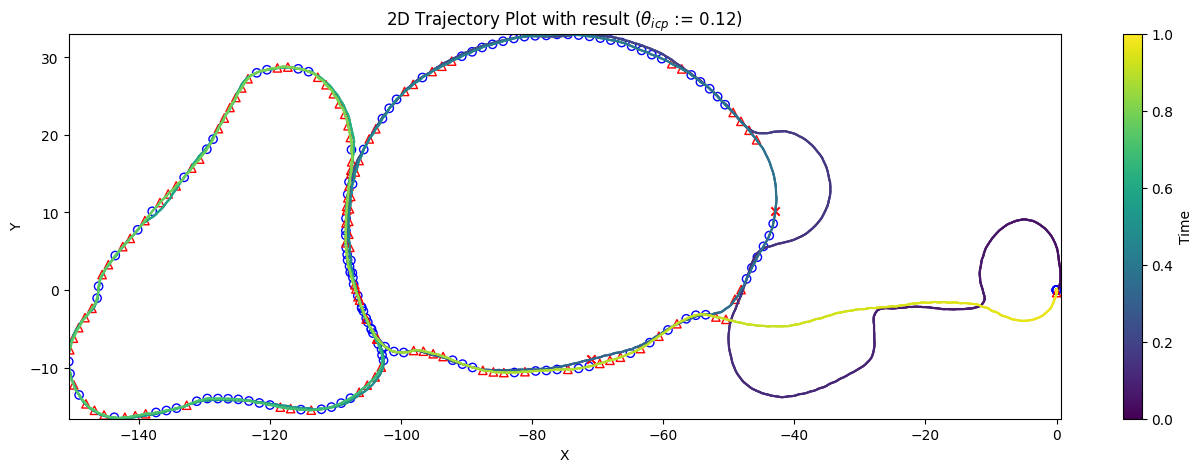

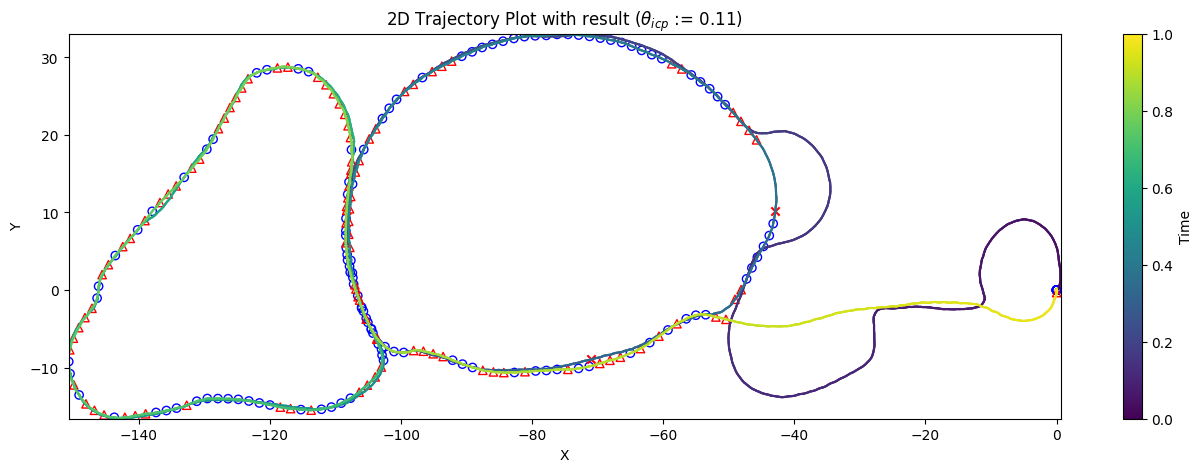

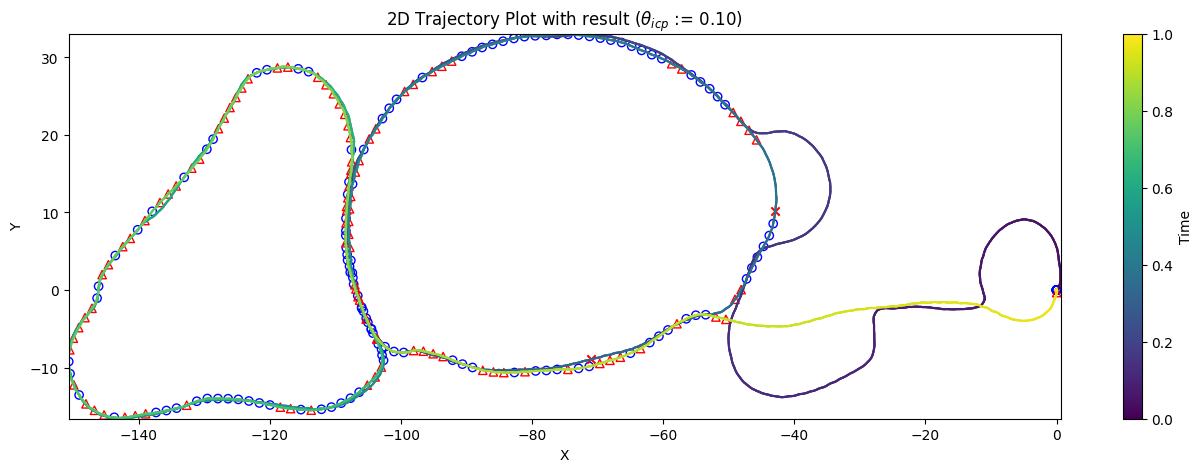

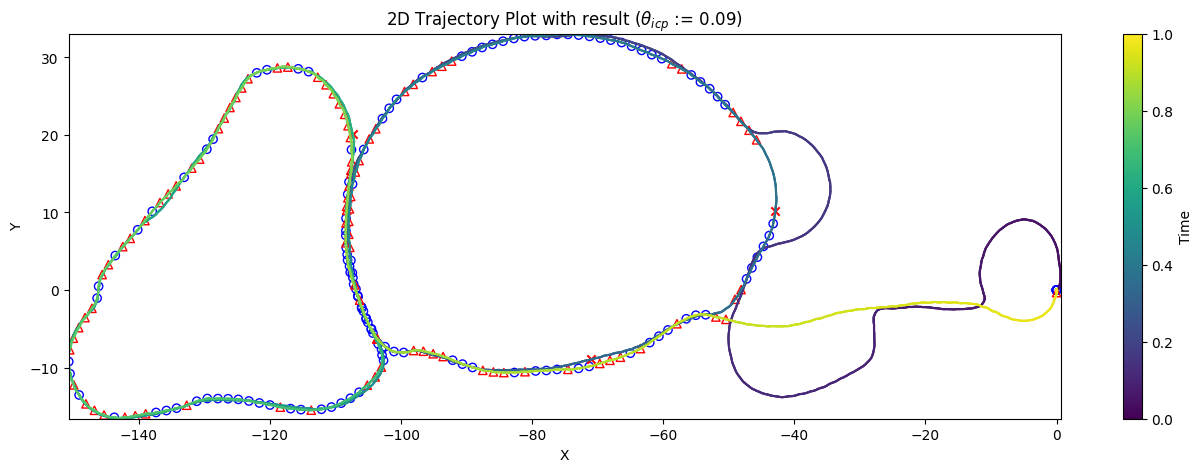

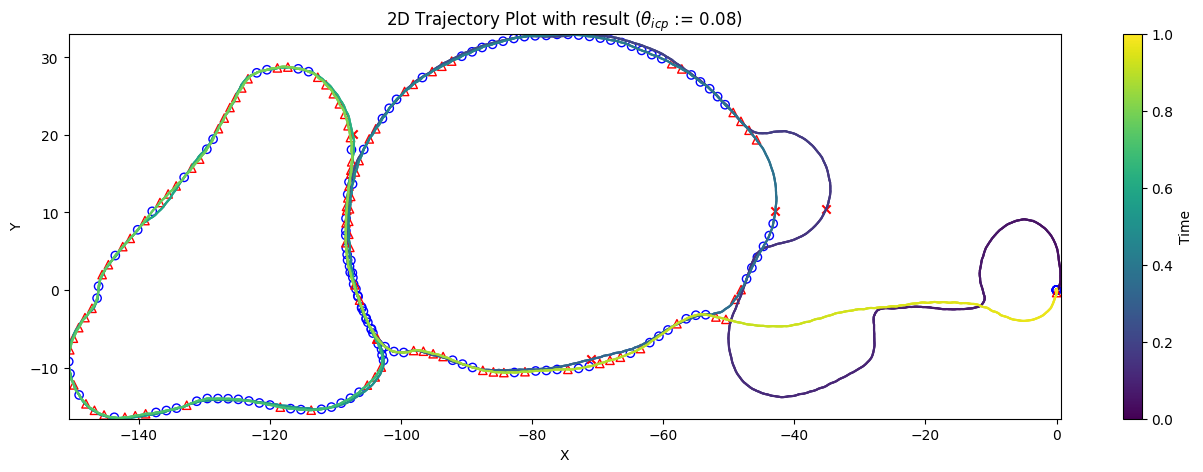

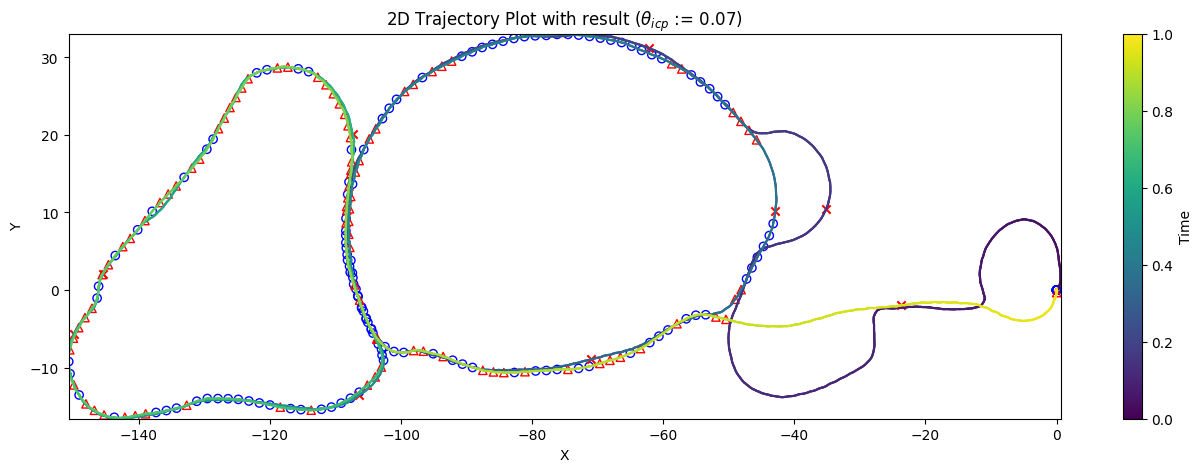

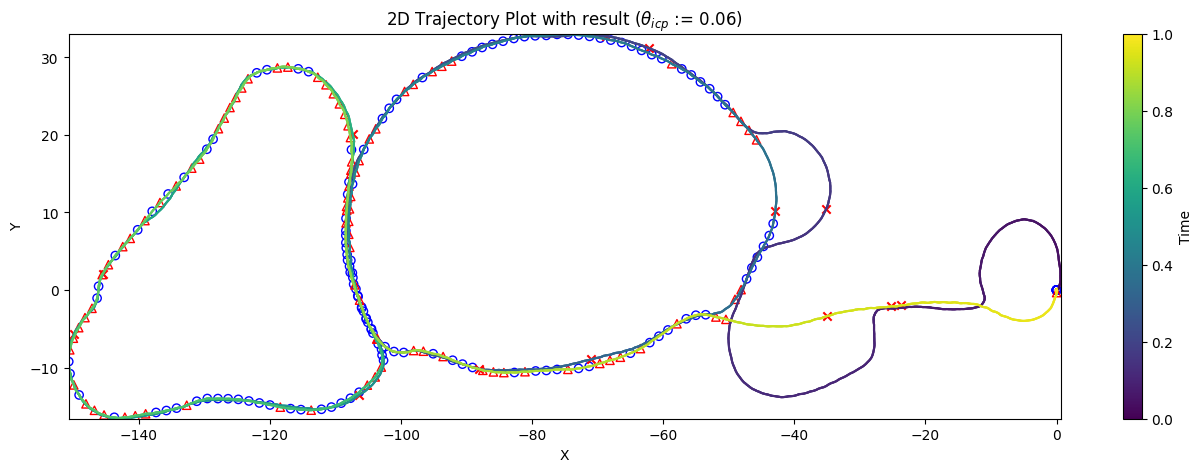

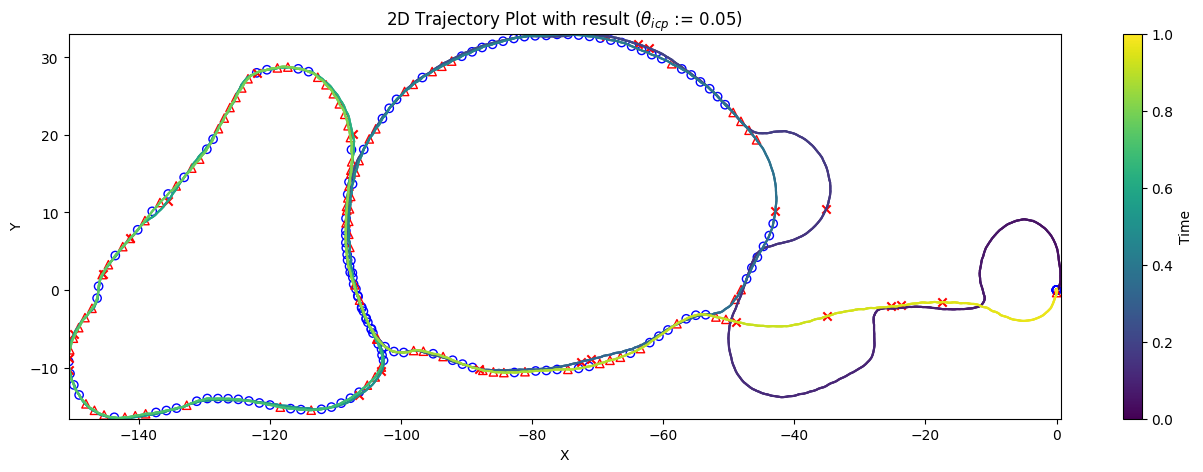

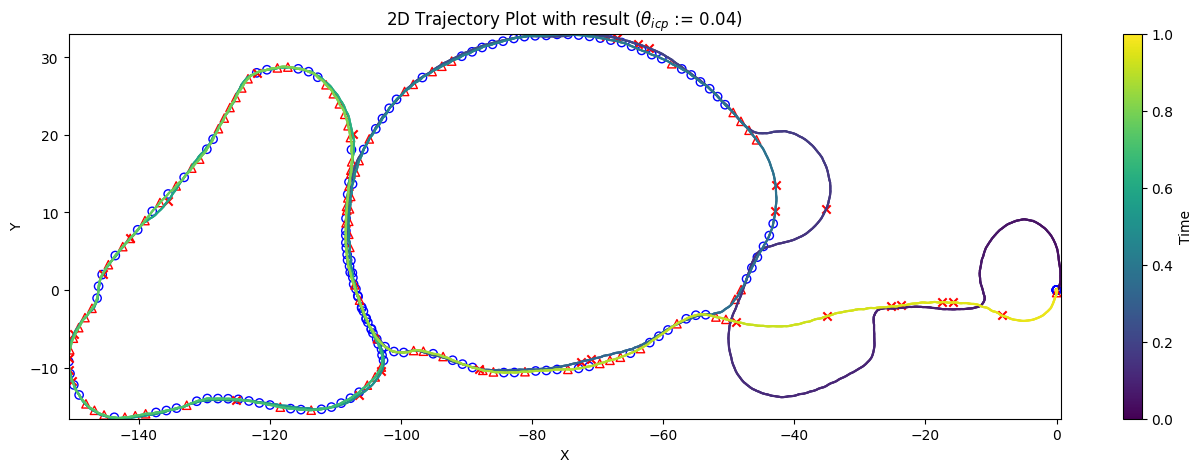

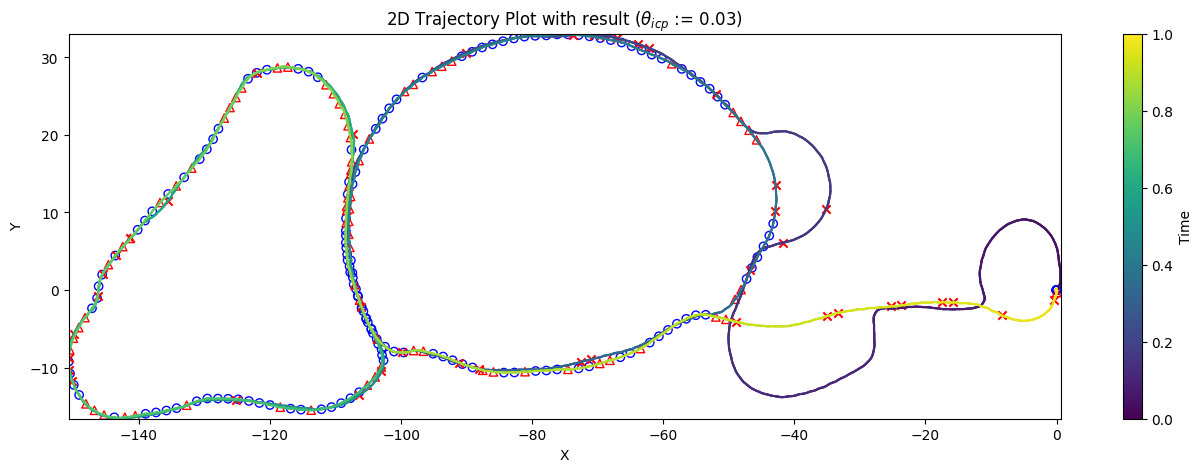

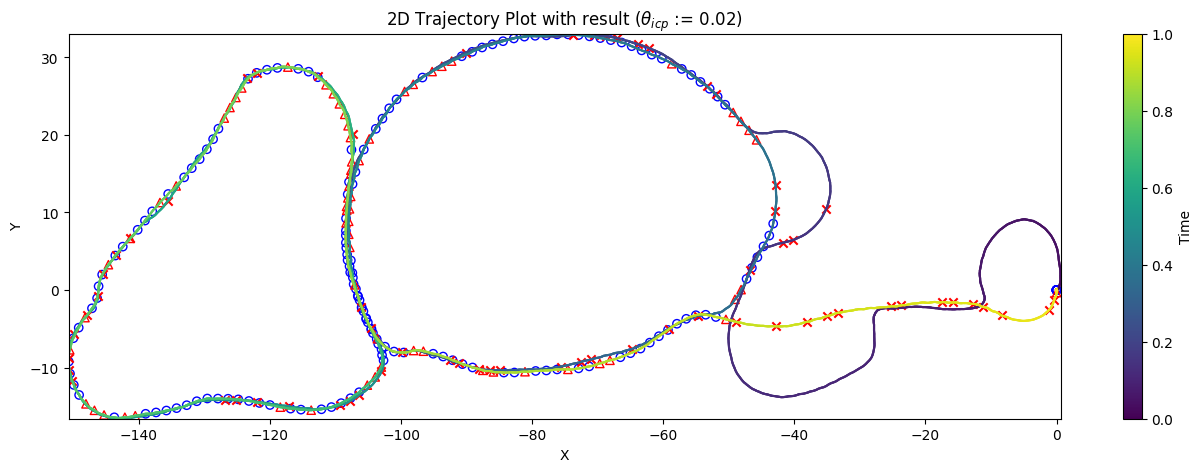

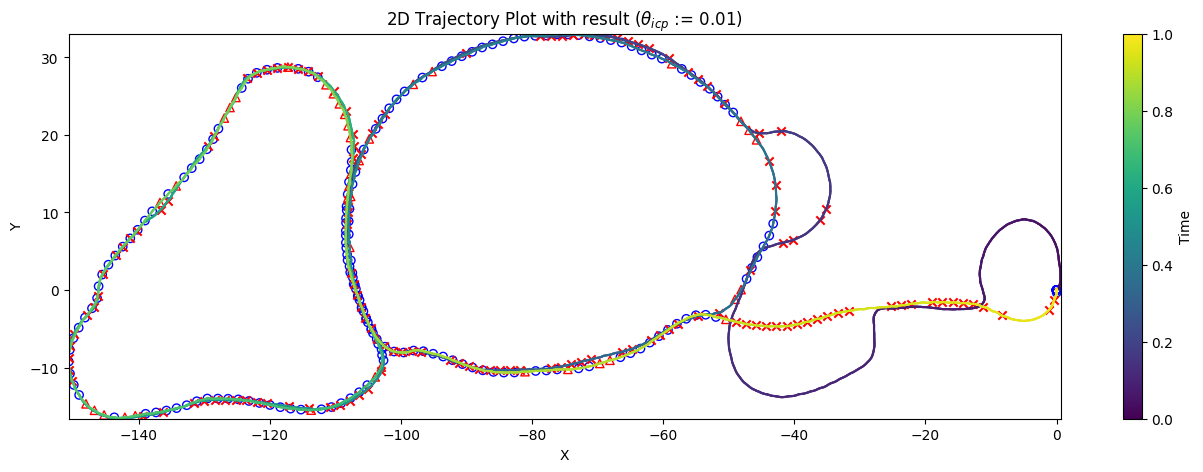

In [19]:
seq_name = 'park_avia'
exid = '231003_except_trees'
plgt_dir = Path('/data/results/MSTD/230926_pseudo_loop_gt_detection/')

loop_fn = f"{RESULTS_DIR}/{exid}/{seq_name}_02-z_max=15.0/result.csv"
loop_data = np.genfromtxt(loop_fn, delimiter=',')
plgt_data = get_plgt_data('02')

thres_arr = np.linspace(0.2, 0.0, num=21).tolist()
for score_thres in thres_arr[:-1]:
    plot_trajectory_with_result(park_avia_02_pose, loop_data, plgt_data, score_thres, '02')


In [ ]:
fig, ax = plt.subplots()
line, = ax.plot([], [], 'bo-')

def init():
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 1)
    return line,

def update(frame):
    x = range(10)
    y = [i / 10 for i in x]
    line.set_data(x[:frame], y[:frame])
    return line,

ani = FuncAnimation(fig, update, frames=10, init_func=init, blit=True)
plt.show()

In [3]:
park1_loop_fn = "results_avia_park/std_result_park1.csv"
park2_loop_fn = "results_avia_park/std_result_park2.csv"
park1_time_fn = "results_avia_park/std_consumption_park1.csv"
park2_time_fn = "results_avia_park/std_consumption_park2.csv"
park1_part_fn = "results_avia_park/std_avia_park1_loop_times.csv"
park2_part_fn = "results_avia_park/std_avia_park2_loop_times.csv"

In [4]:
park1_loop = np.genfromtxt(park1_loop_fn, delimiter=',')
park2_loop = np.genfromtxt(park2_loop_fn, delimiter=',')
park1_time = np.genfromtxt(park1_time_fn, delimiter=',')
park2_time = np.genfromtxt(park2_time_fn, delimiter=',')
park1_part = np.genfromtxt(park1_part_fn, delimiter=',')
park2_part = np.genfromtxt(park2_part_fn, delimiter=',')
print("park1_loop.shape: ", park1_loop.shape)
print("park2_loop.shape: ", park2_loop.shape)
print("park1_time.shape: ", park1_time.shape)
print("park2_time.shape: ", park2_time.shape)
print("park1_part.shape: ", park1_part.shape)
print("park2_part.shape: ", park2_part.shape)

def is_in_part(t_sec, part_data):
    flag = False
    eps = 0.01
    for i in range(part_data.shape[0]):
        if     t_sec >= (part_data[i,0] - eps) \
           and t_sec <= (part_data[i,1] + eps):
            flag = True
    return flag

park1_loop.shape:  (598, 8)
park2_loop.shape:  (539, 8)
park1_time.shape:  (598, 3)
park2_time.shape:  (539, 3)
park1_part.shape:  (6, 2)
park2_part.shape:  (5, 2)


## For Avia Park Dataset

### Parse Pseudo Loop GT

In [25]:
def parse_pseudo_loop_gt(src_dir:Path, exid:str, threshold:float, use_union_div):
    data_fn = (Path(src_dir) / exid / 'pseudo_loop_gt.txt')
    data = np.genfromtxt(data_fn, delimiter=',') 
    if use_union_div:
        data = data[:,1] >= threshold
        return data
    else:
        data = data[:,0] >= threshold
        return data

In [21]:
plgt_data = parse_pseudo_loop_gt(
    '/data/results/MSTD/230926_pseudo_loop_gt_detection/',
    'park_avia_01_vvt=5', 0.4, True)

if not src_dir.is_dir():
    print(f"{src_dir} is not directory!")

for child_dir in src_dir.iterdir():
    if 'park' in child_dir.name:
        data = parse_pseudo_loop_gt(child_dir, 0.5)
        if data is not None:
            print(f"{child_dir}: {data.shape[0]}")

/data/results/MSTD/230926_pseudo_loop_gt_detection/park_avia_01_vvt=5: 598
/data/results/MSTD/230926_pseudo_loop_gt_detection/park_avia_01_vvt=1: 598
/data/results/MSTD/230926_pseudo_loop_gt_detection/park_avia_01_vvt=3: 598
/data/results/MSTD/230926_pseudo_loop_gt_detection/park_avia_02_vvt=5: 539
/data/results/MSTD/230926_pseudo_loop_gt_detection/park_avia_01_vvt=10: 598
/data/results/MSTD/230926_pseudo_loop_gt_detection/park_avia_02_vvt=10: 539
/data/results/MSTD/230926_pseudo_loop_gt_detection/park_avia_02_vvt=3: 144
/data/results/MSTD/230926_pseudo_loop_gt_detection/park_avia_02_vvt=1: 0


/tmp/ipykernel_405/2792222811.py:4: UserWarning: genfromtxt: Empty input file: "/data/results/MSTD/230926_pseudo_loop_gt_detection/park_avia_02_vvt=1/pseudo_loop_gt.txt"
  data = np.genfromtxt(data_fn, delimiter=',')


In [15]:
park1_loop_fn = "results_avia_park/std_result_park1.csv"
park2_loop_fn = "results_avia_park/std_result_park2.csv"
park1_time_fn = "results_avia_park/std_consumption_park1.csv"
park2_time_fn = "results_avia_park/std_consumption_park2.csv"
park1_part_fn = "results_avia_park/std_avia_park1_loop_times.csv"
park2_part_fn = "results_avia_park/std_avia_park2_loop_times.csv"
park1_loop = np.genfromtxt(park1_loop_fn, delimiter=',')
park2_loop = np.genfromtxt(park2_loop_fn, delimiter=',')
park1_time = np.genfromtxt(park1_time_fn, delimiter=',')
park2_time = np.genfromtxt(park2_time_fn, delimiter=',')
park1_part = np.genfromtxt(park1_part_fn, delimiter=',')
park2_part = np.genfromtxt(park2_part_fn, delimiter=',')
print("park1_loop.shape: ", park1_loop.shape)
print("park2_loop.shape: ", park2_loop.shape)
print("park1_time.shape: ", park1_time.shape)
print("park2_time.shape: ", park2_time.shape)
print("park1_part.shape: ", park1_part.shape)
print("park2_part.shape: ", park2_part.shape)

park1_loop.shape:  (598, 8)
park2_loop.shape:  (539, 8)
park1_time.shape:  (598, 3)
park2_time.shape:  (539, 3)
park1_part.shape:  (6, 2)
park2_part.shape:  (5, 2)


In [ ]:

SKIP_NUM = 50
SKIP_NEAR_NUM = 100
ARG_SCORE_THRES = 0.1
ARG_LOOP_THRES = 10.0

In [31]:
loop_data = park1_loop
time_data = park1_time
part_data = park1_part
plgt_data = parse_pseudo_loop_gt(
    '/data/results/MSTD/230926_pseudo_loop_gt_detection/',
    'park_avia_01_vvt=5', 0.4, True)

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

assert(loop_data.shape[0] == time_data.shape[0])
N_DATA = loop_data.shape[0]

if N_DATA <= SKIP_NUM:
    print(f"[WARN] dataset length({N_DATA}) is smaller than skip length({SKIP_NUM})")
    exit(0)

for i in range(SKIP_NUM, N_DATA): #
    t_sec = loop_data[i,0]
    score = loop_data[i,1]
    
    # t_query = loop_data[i,2:5].reshape((3,1))
    # t_dbase = loop_data[i,5:8].reshape((3,1))
    # loop_candidates = loop_data[0:i-SKIP_NUM+1,2:5]
    # loop_candidates_dist:np.ndarray = loop_candidates - np.tile(t_query.reshape((1,3)), (loop_candidates.shape[0],1))
    # loop_candidates_dist = np.linalg.norm(loop_candidates_dist, axis=1)
    # min_dist = 9999.0
    # if (loop_candidates_dist <= ARG_LOOP_THRES).any():
    #     min_dist = loop_candidates_dist.min()
    
    if score >= ARG_SCORE_THRES:
        if plgt_data[i]:
            # print(f"[Succ] Idx({i:03d}): Score({score:2.4f} / Dist({l2_dist:2.4f}))")  
            true_positive  += 1
        else:
            # print(f"[Fail] Idx({i:03d}): Score({score:2.4f} / Dist({l2_dist:2.4f}))")  
            false_positive += 1
    else:
        if plgt_data[i]:
            # print(f"Fail to detect loop, Score({score:2.4f} vs Min({min_dist:2.4f})")
            false_negative += 1
        else:
            true_negative  += 1

print(f"true_positive: {true_positive}")
print(f"true_negative: {true_negative}")
print(f"false_positive: {false_positive}")
print(f"false_negative: {false_negative}")

true_positive: 40
true_negative: 395
false_positive: 28
false_negative: 85


In [42]:
# def compute_precision_recall_etc(loop_data, plgt_data, score_thres):
#     """ compute precision & Recall 

#     Args:
#         loop_data (np.ndarray): N x 8 Result data
#         part_data (np.ndarray): part data which includes loop timing information
#     """    
#     true_positive = 0
#     true_negative = 0
#     false_positive = 0
#     false_negative = 0

#     N_DATA = loop_data.shape[0]

#     if N_DATA <= SKIP_NUM:
#         print(f"[WARN] dataset length({N_DATA}) is smaller than skip length({SKIP_NUM})")
#         exit(0)

#     for i in range(SKIP_NUM, N_DATA):
#         score = loop_data[i,1]
        
#         if score >= score_thres:
#             if plgt_data[i]:
#                 true_positive  += 1
#             else:
#                 false_positive += 1
#         else:
#             if plgt_data[i]:
#                 false_negative += 1
#             else:
#                 true_negative  += 1
    
#     etc = [ true_positive, false_positive,
#             true_negative, false_negative ]
#     if true_positive == 0:
#         return 0.0, 0.0, etc
    
#     precision = true_positive / (true_positive + false_positive)
#     recall = true_positive / (true_positive + false_negative)
#     return precision, recall, etc

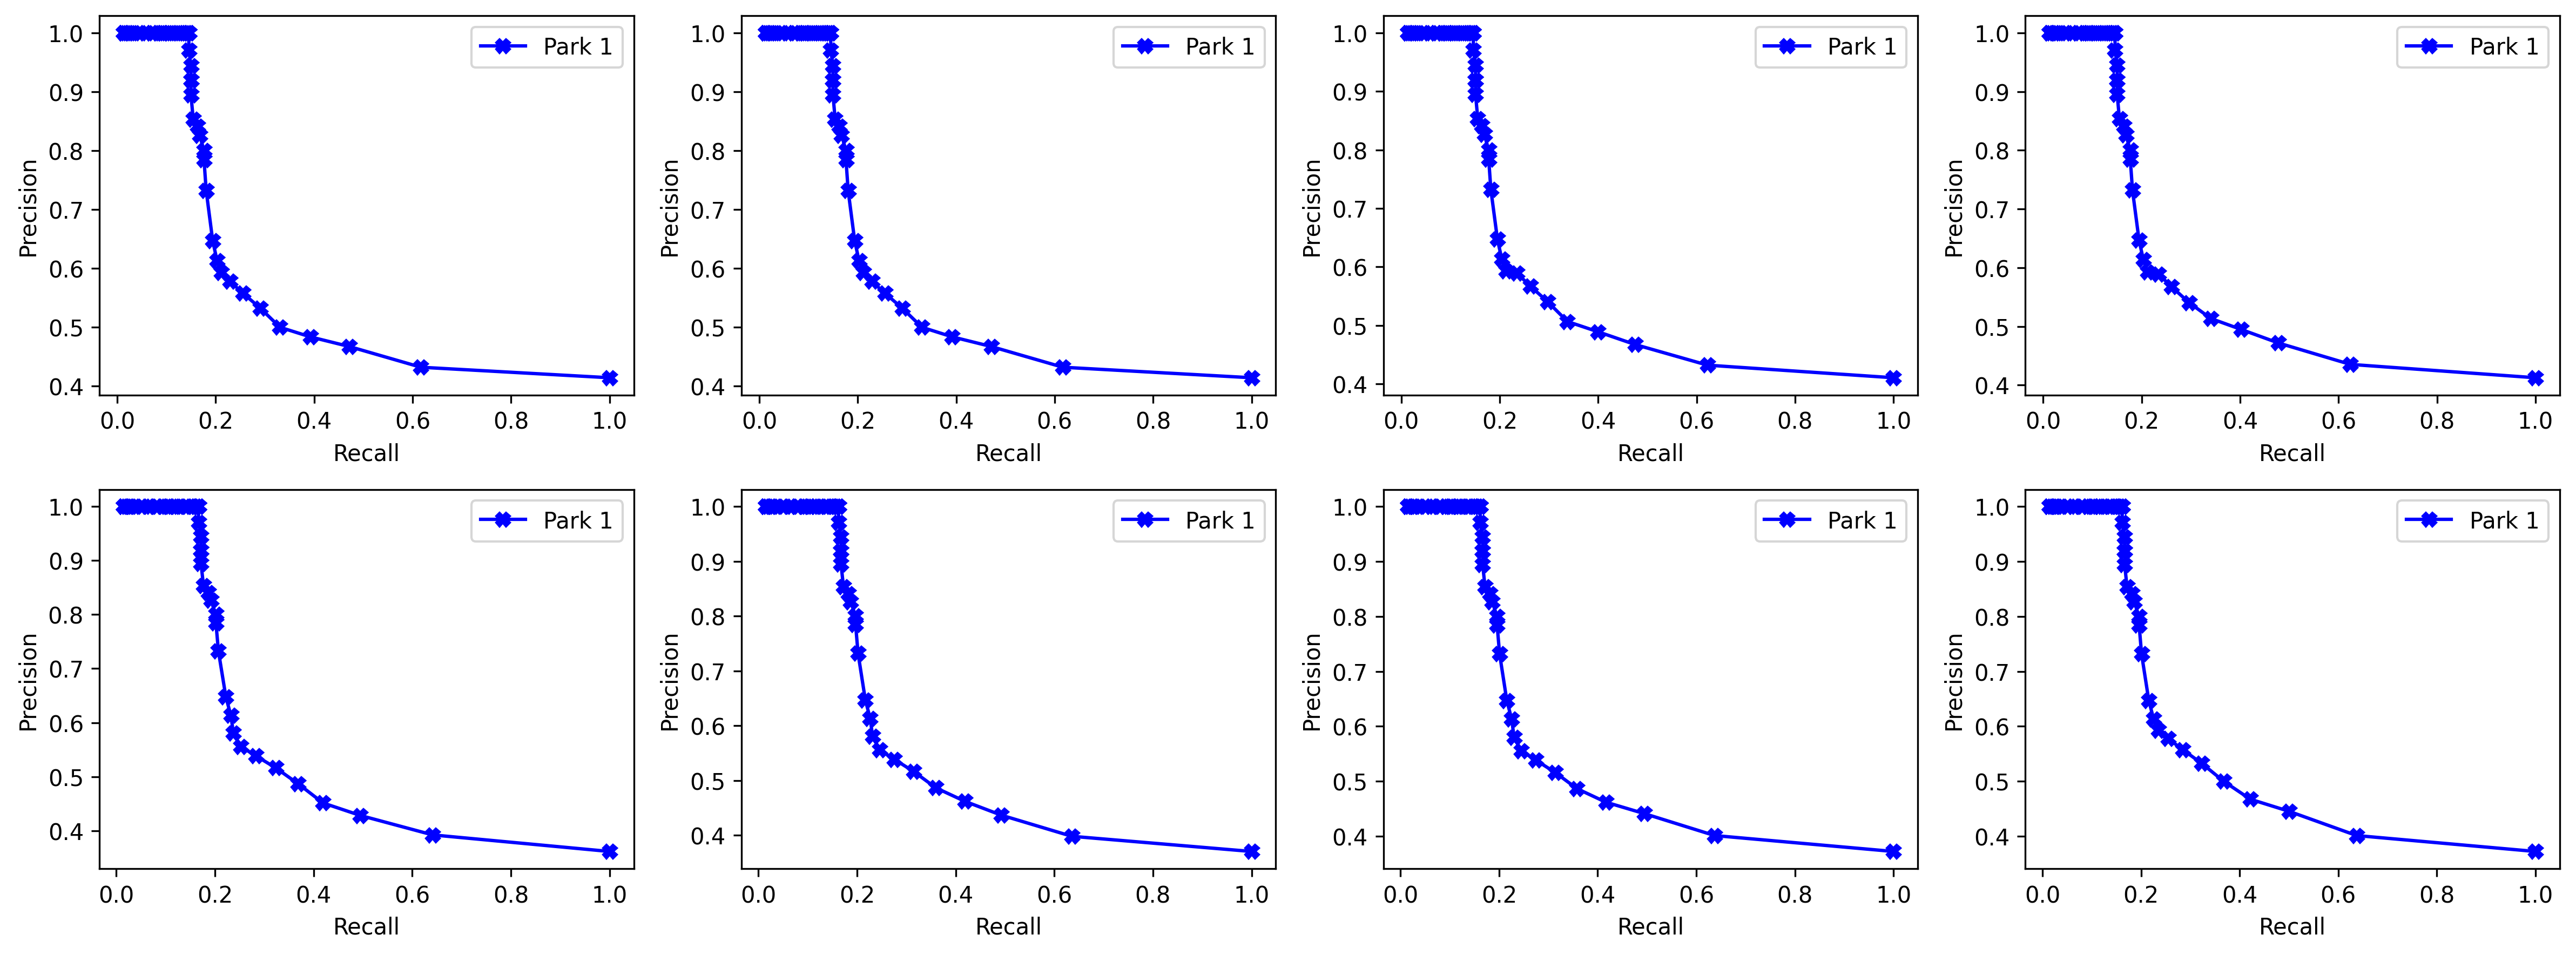

In [50]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6), dpi=300)

use_overlap = False

row = 0
col = 0

for vvt in [1, 3, 5, 10]:
    for ratio_thres in [0.3, 0.4]:
                
        thres_arr = np.linspace(0.5, 0.0, num=51).tolist()
        # print(thres_arr)

        loop_data = park1_loop
        time_data = park1_time
        plgt_data = parse_pseudo_loop_gt(
            '/data/results/MSTD/230926_pseudo_loop_gt_detection/',
            f'park_avia_01_vvt={vvt}', ratio_thres, use_overlap)

        xs = []
        precisions = []
        recalls = []

        for i in range(len(thres_arr)):
            precision, recall, etc = compute_precision_recall_etc(loop_data, plgt_data, thres_arr[i])
            xs.append(thres_arr[i])
            precisions.append(precision)
            recalls.append(recall)
            

        xs = np.array(xs, dtype=float)
        precisions = np.array(precisions, dtype=float)
        recalls = np.array(recalls, dtype=float)
        
        # Plot data on the first subplot (top)
        axes[row][col].plot(recalls, precisions, label='Park 1', color='b', marker='X')
        # axes[0].set_title('Line Graph 1')
        axes[row][col].set_xlabel('Recall')
        axes[row][col].set_ylabel('Precision')
        axes[row][col].legend()


        row = (row + 1) % 2
    col = (col + 1) % 4

# # Plot data on the first subplot (top)
# axes[0].plot(recalls, precisions, label='Park 1', color='b', marker='X')
# # axes[0].set_title('Line Graph 1')
# axes[0].set_xlabel('Recall')
# axes[0].set_ylabel('Precision')
# axes[0].legend()

# # Plot data on the second subplot (bottom)
# axes[1].plot(xs, recalls,      label='recall', color='g')
# axes[1].plot(xs, 1-precisions, label='1-precision', color='r')
# # axes[1].set_title('Line Graph 2')
# axes[1].set_xlabel('Plane coincidence threshold')
# axes[1].set_ylabel('Rates')
# axes[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Draw Trajectories

In [35]:
gt1_data = np.genfromtxt('/data/datasets/dataset_std/park_avia/park1_pose.txt')
gt2_data = np.genfromtxt('/data/datasets/dataset_std/park_avia/park2_pose.txt')

park_avia_01_pose = np.genfromtxt('/data/datasets/dataset_std/park_avia/park1_pose.txt')
park_avia_01_vvt5_loop = np.genfromtxt('/root/cw-eval-tools/eval_std/results_avia_park/std_park_avia_01_pseudo_loop_vvt5.csv', delimiter=',')
print(f'park_avia_01_pose shape: {park_avia_01_pose.shape}')
print(f'park_avia_01_vvt5_loop shape: {park_avia_01_vvt5_loop.shape}')

park_avia_02_pose = np.genfromtxt('/data/datasets/dataset_std/park_avia/park2_pose.txt')
park_avia_02_vvt5_loop = np.genfromtxt('/root/cw-eval-tools/eval_std/results_avia_park/std_park_avia_02_pseudo_loop_vvt5.csv', delimiter=',')
print(f'park_avia_02_pose shape: {park_avia_02_pose.shape}')
print(f'park_avia_02_vvt5_loop shape: {park_avia_02_vvt5_loop.shape}')

Before aligned | x_min:-24.72 x_max:45.18
Before aligned | y_min:-3.90 y_max:153.60
Before aligned | z_min:-0.01 z_max:10.08
Align R.T:
 [[-0.1464712   0.98921027 -0.00303869]
 [ 0.98747137  0.14603004 -0.05979572]
 [ 0.0587068   0.01175897  0.99820601]]
After  aligned | x_min:-8.41 x_max:154.46
After  aligned | y_min:-7.64 y_max:46.22
After  aligned | z_min:-0.23 z_max:1.48


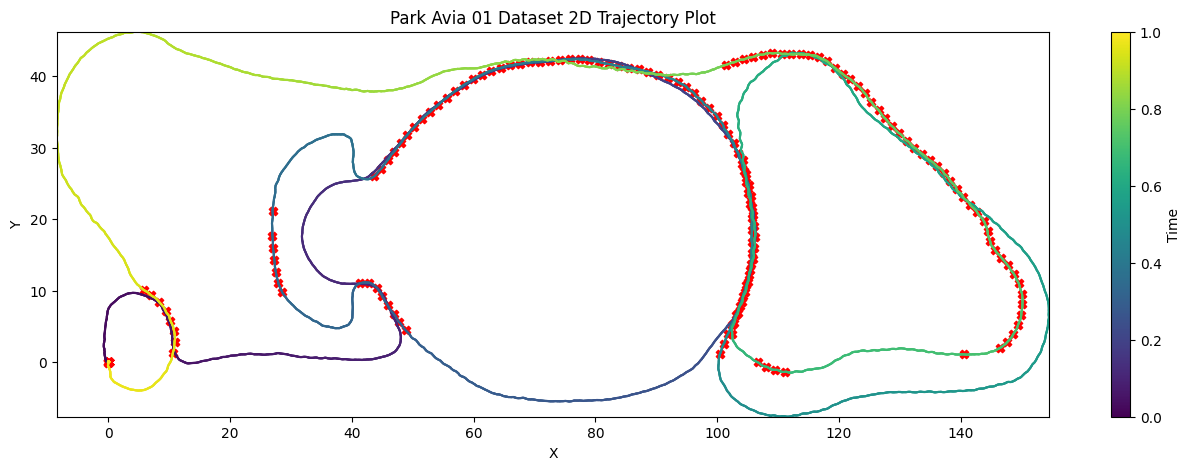

In [47]:
plot_traj_and_loop(park_avia_01_pose, park_avia_01_vvt5_loop, seq='01')

Before aligned | x_min:-24.72 x_max:45.18
Before aligned | y_min:-3.90 y_max:153.60
Before aligned | z_min:-0.01 z_max:10.08
Align R.T:
 [[-0.1464712   0.98921027 -0.00303869]
 [ 0.98747137  0.14603004 -0.05979572]
 [ 0.0587068   0.01175897  0.99820601]]
After  aligned | x_min:-8.41 x_max:154.46
After  aligned | y_min:-7.64 y_max:46.22
After  aligned | z_min:-0.23 z_max:1.48


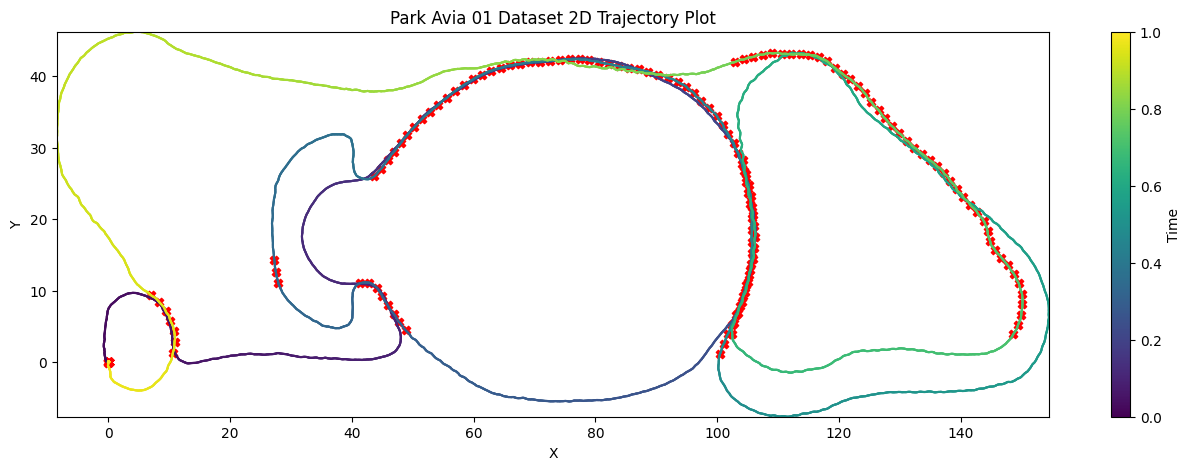

In [49]:
plot_traj_and_loop(park_avia_01_pose, park_avia_01_vvt5_loop, seq='01')

Before aligned | x_min:-24.72 x_max:45.18
Before aligned | y_min:-3.90 y_max:153.60
Before aligned | z_min:-0.01 z_max:10.08
Align R.T:
 [[-0.1464712   0.98921027 -0.00303869]
 [ 0.98747137  0.14603004 -0.05979572]
 [ 0.0587068   0.01175897  0.99820601]]
After  aligned | x_min:-8.41 x_max:154.46
After  aligned | y_min:-7.64 y_max:46.22
After  aligned | z_min:-0.23 z_max:1.48


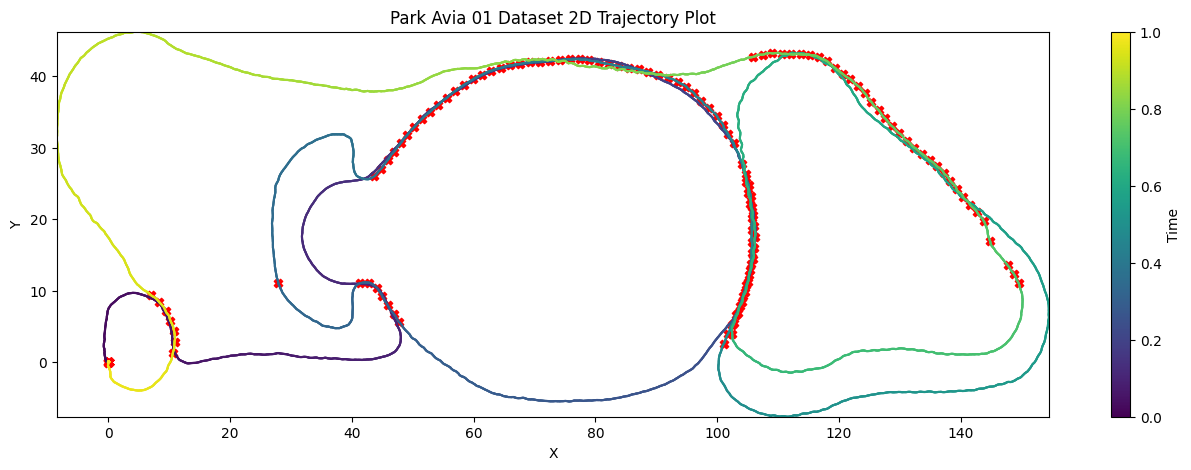

In [51]:
plot_traj_and_loop(park_avia_01_pose, park_avia_01_vvt5_loop, seq='01')

Before aligned | x_min:-37.31 x_max:22.37
Before aligned | y_min:-0.43 y_max:147.81
Before aligned | z_min:-0.02 z_max:5.83
Align R.T:
 [[ 0.14564089  0.98932085 -0.00574336]
 [-0.98859487  0.14530422 -0.03958364]
 [-0.03832638  0.01144285  0.99919975]]
After  aligned | x_min:-150.74 x_max:0.60
After  aligned | y_min:-16.58 y_max:33.03
After  aligned | z_min:-0.02 z_max:0.61


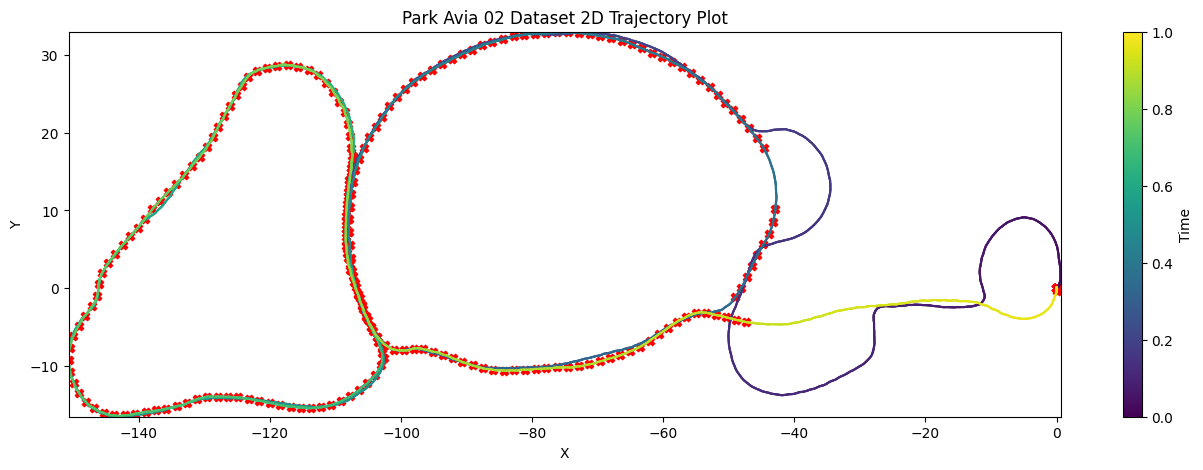

In [45]:
plot_traj_and_loop(park_avia_02_pose, park_avia_02_vvt5_loop, seq='02')

Before aligned | x_min:-37.31 x_max:22.37
Before aligned | y_min:-0.43 y_max:147.81
Before aligned | z_min:-0.02 z_max:5.83
Align R.T:
 [[ 0.14564089  0.98932085 -0.00574336]
 [-0.98859487  0.14530422 -0.03958364]
 [-0.03832638  0.01144285  0.99919975]]
After  aligned | x_min:-150.74 x_max:0.60
After  aligned | y_min:-16.58 y_max:33.03
After  aligned | z_min:-0.02 z_max:0.61


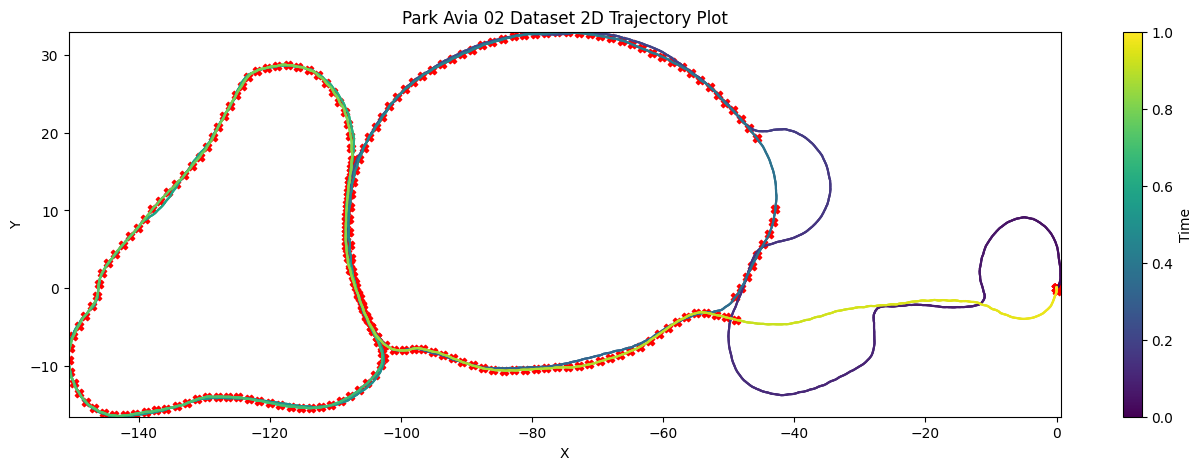

In [38]:
plot_traj_and_loop(park_avia_02_pose, park_avia_02_vvt5_loop, seq='02')

Before aligned | x_min:-37.31 x_max:22.37
Before aligned | y_min:-0.43 y_max:147.81
Before aligned | z_min:-0.02 z_max:5.83
Align R.T:
 [[ 0.14564089  0.98932085 -0.00574336]
 [-0.98859487  0.14530422 -0.03958364]
 [-0.03832638  0.01144285  0.99919975]]
After  aligned | x_min:-150.74 x_max:0.60
After  aligned | y_min:-16.58 y_max:33.03
After  aligned | z_min:-0.02 z_max:0.61


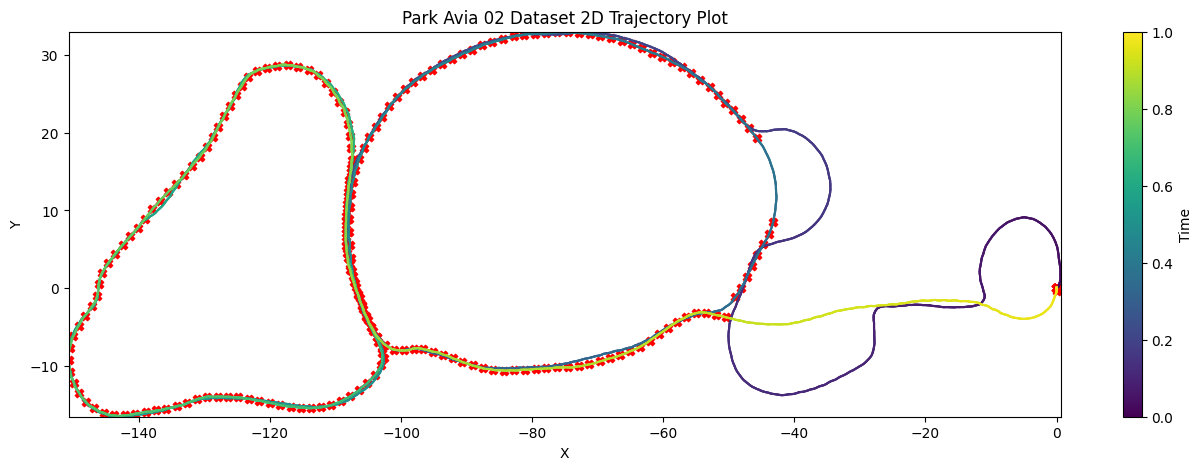

In [42]:
plot_traj_and_loop(park_avia_02_pose, park_avia_02_vvt5_loop, seq='02')

## Evaluation

In [ ]:
def compute_precision_recall_etc(loop_data, part_data, score_thres):
    """ compute precision & Recall 

    Args:
        loop_data (np.ndarray): N x 8 Result data
        part_data (np.ndarray): part data which includes loop timing information
    """  
    SKIP_NUM = 50
    ARG_LOOP_THRES = 20.0
  
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    N_DATA = loop_data.shape[0]

    if N_DATA <= SKIP_NUM:
        print(f"[WARN] dataset length({N_DATA}) is smaller than skip length({SKIP_NUM})")
        exit(0)

    for i in range(SKIP_NUM, N_DATA): #
        t_sec = loop_data[i,0]
        score = loop_data[i,1]
        t_query = loop_data[i,2:5].reshape((3,1))
        t_dbase = loop_data[i,5:8].reshape((3,1))
        
        # is_loop = False
        
        loop_candidates = loop_data[0:i-SKIP_NUM+1,2:5]
        loop_candidates_dist:np.ndarray = loop_candidates - np.tile(t_query.reshape((1,3)), (loop_candidates.shape[0],1))
        loop_candidates_dist = np.linalg.norm(loop_candidates_dist, axis=1)
        min_dist = 9999.0
        # print("loop_candidates_dist: ", loop_candidates_dist.shape)
        # print(loop_candidates_dist.tolist())
        if (loop_candidates_dist <= ARG_LOOP_THRES).any():
            # print(f"Loop exists")
            # is_loop = True
            min_dist = loop_candidates_dist.min()
        
        is_loop = is_in_part(t_sec, part_data)
        
        if score >= score_thres:
            l2_dist = ((t_query - t_dbase) ** 2)
            l2_dist = np.sqrt(np.sum(l2_dist))
            
            if is_loop or l2_dist <= ARG_LOOP_THRES:
                # print(f"[Succ] Idx({i:03d}): Score({score:2.4f} / Dist({l2_dist:2.4f}))")  
                true_positive += 1
            else:
                # print(f"[Fail] Idx({i:03d}): Score({score:2.4f} / Dist({l2_dist:2.4f}))")  
                false_positive += 1
        else:
            if is_loop:
                # print(f"Fail to detect loop, Score({score:2.4f} vs Min({min_dist:2.4f})")
                false_negative += 1
            else:
                true_negative += 1
                pass

    # print(f"true_positive: {true_positive}")
    # print(f"true_negative: {true_negative}")
    # print(f"false_positive: {false_positive}")
    # print(f"false_negative: {false_negative}")
    
    etc = [ true_positive, false_positive,
            true_negative, false_negative ]
    if true_positive == 0:
        return 0.0, 0.0, etc
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    return precision, recall, etc

### eval 231003

In [ ]:
gt1_data = np.genfromtxt('/data/datasets/dataset_std/park_avia/park1_pose.txt')
gt2_data = np.genfromtxt('/data/datasets/dataset_std/park_avia/park2_pose.txt')

park_avia_01_pose = np.genfromtxt('/data/datasets/dataset_std/park_avia/park1_pose.txt')
park_avia_01_vvt5_loop = np.genfromtxt('/root/cw-eval-tools/eval_std/results_avia_park/std_park_avia_01_pseudo_loop_vvt5.csv', delimiter=',')
print(f'park_avia_01_pose shape: {park_avia_01_pose.shape}')
print(f'park_avia_01_vvt5_loop shape: {park_avia_01_vvt5_loop.shape}')

park_avia_02_pose = np.genfromtxt('/data/datasets/dataset_std/park_avia/park2_pose.txt')
park_avia_02_vvt5_loop = np.genfromtxt('/root/cw-eval-tools/eval_std/results_avia_park/std_park_avia_02_pseudo_loop_vvt5.csv', delimiter=',')
print(f'park_avia_02_pose shape: {park_avia_02_pose.shape}')
print(f'park_avia_02_vvt5_loop shape: {park_avia_02_vvt5_loop.shape}')

thres_arr = np.linspace(0.5, 0.0, 51).tolist()
# print(thres_arr)

loop_data = park1_loop
time_data = park1_time
part_data = park1_part

xs = []
precisions = []
recalls = []

for i in range(len(thres_arr)):
    precision, recall, etc = compute_precision_recall_etc(loop_data, part_data, thres_arr[i])
    xs.append(thres_arr[i])
    precisions.append(precision)
    recalls.append(recall)
    

xs = np.array(xs, dtype=float)
precisions = np.array(precisions, dtype=float)
recalls = np.array(recalls, dtype=float)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot data on the first subplot (top)
axes[0].plot(recalls, precisions, label='Park 1', color='b', marker='X')
# axes[0].set_title('Line Graph 1')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()

# Plot data on the second subplot (bottom)
axes[1].plot(xs, recalls,      label='recall', color='g')
axes[1].plot(xs, 1-precisions, label='1-precision', color='r')
# axes[1].set_title('Line Graph 2')
axes[1].set_xlabel('Plane coincidence threshold')
axes[1].set_ylabel('Rates')
axes[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## Archive

In [7]:
SKIP_NUM = 50
ARG_LOOP_THRES = 20.0

def compute_precision_recall_etc(loop_data, part_data, score_thres):
    """ compute precision & Recall 

    Args:
        loop_data (np.ndarray): N x 8 Result data
        part_data (np.ndarray): part data which includes loop timing information
    """    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    N_DATA = loop_data.shape[0]

    if N_DATA <= SKIP_NUM:
        print(f"[WARN] dataset length({N_DATA}) is smaller than skip length({SKIP_NUM})")
        exit(0)

    for i in range(SKIP_NUM, N_DATA): #
        t_sec = loop_data[i,0]
        score = loop_data[i,1]
        t_query = loop_data[i,2:5].reshape((3,1))
        t_dbase = loop_data[i,5:8].reshape((3,1))
        
        # is_loop = False
        
        loop_candidates = loop_data[0:i-SKIP_NUM+1,2:5]
        loop_candidates_dist:np.ndarray = loop_candidates - np.tile(t_query.reshape((1,3)), (loop_candidates.shape[0],1))
        loop_candidates_dist = np.linalg.norm(loop_candidates_dist, axis=1)
        min_dist = 9999.0
        # print("loop_candidates_dist: ", loop_candidates_dist.shape)
        # print(loop_candidates_dist.tolist())
        if (loop_candidates_dist <= ARG_LOOP_THRES).any():
            # print(f"Loop exists")
            # is_loop = True
            min_dist = loop_candidates_dist.min()
        
        is_loop = is_in_part(t_sec, part_data)
        
        if score >= score_thres:
            l2_dist = ((t_query - t_dbase) ** 2)
            l2_dist = np.sqrt(np.sum(l2_dist))
            
            if is_loop or l2_dist <= ARG_LOOP_THRES:
                # print(f"[Succ] Idx({i:03d}): Score({score:2.4f} / Dist({l2_dist:2.4f}))")  
                true_positive += 1
            else:
                # print(f"[Fail] Idx({i:03d}): Score({score:2.4f} / Dist({l2_dist:2.4f}))")  
                false_positive += 1
        else:
            if is_loop:
                # print(f"Fail to detect loop, Score({score:2.4f} vs Min({min_dist:2.4f})")
                false_negative += 1
            else:
                true_negative += 1
                pass

    # print(f"true_positive: {true_positive}")
    # print(f"true_negative: {true_negative}")
    # print(f"false_positive: {false_positive}")
    # print(f"false_negative: {false_negative}")
    
    etc = [ true_positive, false_positive,
            true_negative, false_negative ]
    if true_positive == 0:
        return 0.0, 0.0, etc
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    return precision, recall, etc

In [ ]:

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839178.0999,1577839235.1994],
                      [1577839331.1998,1577839346.0998],
                      [1577839390.0998,1577839417.1995],
                      [1577839519.0996,1577839523.0996],
                      [1577839536.0999,1577839549.1996]])

# - 1
part_data = np.array([[1577839178.0999,1577839235.1994],
                      [1577839331.1998,1577839346.0998],
                      [1577839390.0998,1577839417.1995],
                      [1577839519.0996,1577839523.0996],
                      [1577839536.0999,1577839549.1996]])

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839331.1998,1577839346.0998],
                      [1577839390.0998,1577839417.1995],
                      [1577839519.0996,1577839523.0996],
                      [1577839536.0999,1577839549.1996]])

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839178.0999,1577839235.1994],
                      [1577839390.0998,1577839417.1995],
                      [1577839519.0996,1577839523.0996],
                      [1577839536.0999,1577839549.1996]])

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839178.0999,1577839235.1994],
                      [1577839331.1998,1577839346.0998],
                      [1577839519.0996,1577839523.0996],
                      [1577839536.0999,1577839549.1996]])

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839178.0999,1577839235.1994],
                      [1577839331.1998,1577839346.0998],
                      [1577839390.0998,1577839417.1995],
                      [1577839536.0999,1577839549.1996]])

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839178.0999,1577839235.1994],
                      [1577839331.1998,1577839346.0998],
                      [1577839390.0998,1577839417.1995],
                      [1577839519.0996,1577839523.0996]])

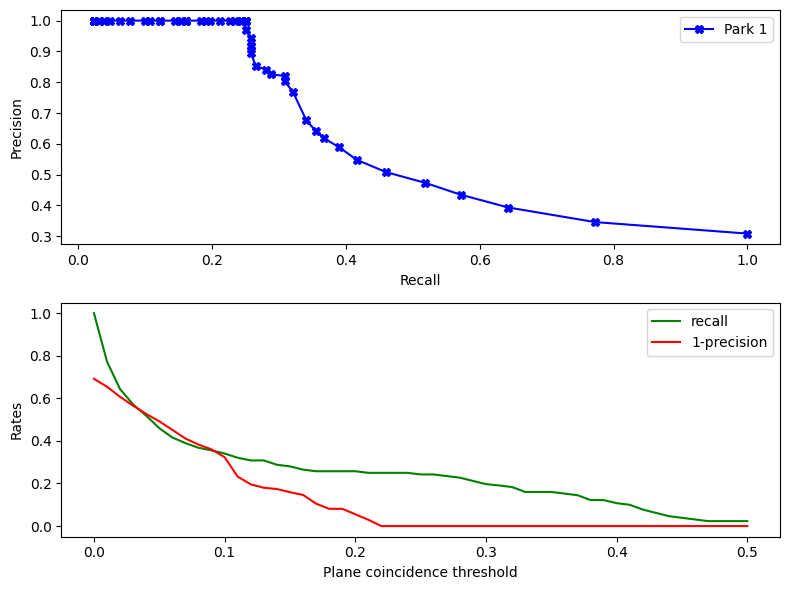

In [8]:

thres_arr = np.linspace(0.5, 0.0, 51).tolist()
# print(thres_arr)

loop_data = park1_loop
time_data = park1_time
part_data = park1_part

xs = []
precisions = []
recalls = []

for i in range(len(thres_arr)):
    precision, recall, etc = compute_precision_recall_etc(loop_data, part_data, thres_arr[i])
    xs.append(thres_arr[i])
    precisions.append(precision)
    recalls.append(recall)
    

xs = np.array(xs, dtype=float)
precisions = np.array(precisions, dtype=float)
recalls = np.array(recalls, dtype=float)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot data on the first subplot (top)
axes[0].plot(recalls, precisions, label='Park 1', color='b', marker='X')
# axes[0].set_title('Line Graph 1')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()

# Plot data on the second subplot (bottom)
axes[1].plot(xs, recalls,      label='recall', color='g')
axes[1].plot(xs, 1-precisions, label='1-precision', color='r')
# axes[1].set_title('Line Graph 2')
axes[1].set_xlabel('Plane coincidence threshold')
axes[1].set_ylabel('Rates')
axes[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


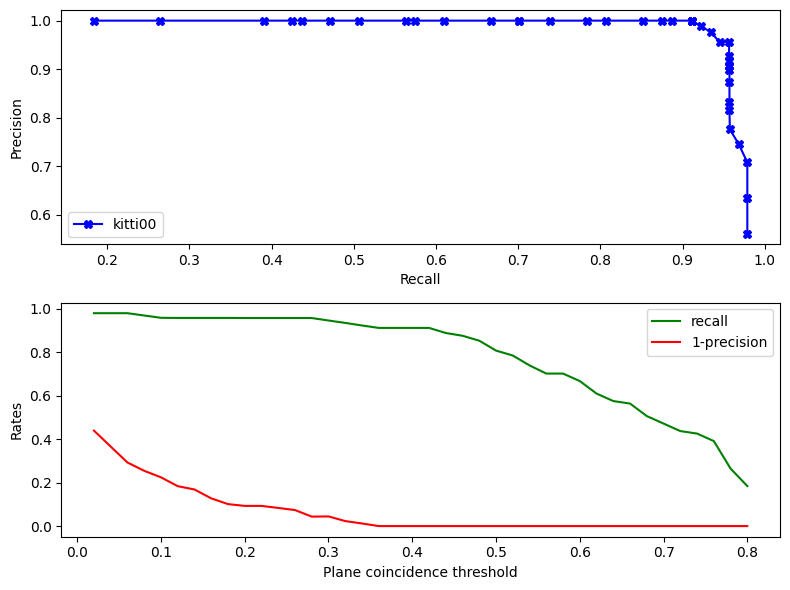

In [35]:
seq = "kitti00"
loop_fn = f"results_kitti/{seq}_std_loop.csv"
time_fn = f"results_kitti/{seq}_std_time.csv"
part_fn = f"results_kitti/{seq}_part.csv"
loop_data = np.genfromtxt(loop_fn, delimiter=',')
time_data = np.genfromtxt(time_fn, delimiter=',')
part_data = np.genfromtxt(part_fn, delimiter=',')

thres_arr = np.linspace(0.02, 0.8, 40).tolist()

xs = []
precisions = []
recalls = []

for i in range(len(thres_arr)):
    precision, recall, etc = compute_precision_recall_etc(loop_data, part_data, thres_arr[i])
    xs.append(thres_arr[i])
    precisions.append(precision)
    recalls.append(recall)
    

xs = np.array(xs, dtype=float)
precisions = np.array(precisions, dtype=float)
recalls = np.array(recalls, dtype=float)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot data on the first subplot (top)
axes[0].plot(recalls, precisions, label=seq, color='b', marker='X')
# axes[0].set_title('Line Graph 1')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()

# Plot data on the second subplot (bottom)
axes[1].plot(xs, recalls,      label='recall', color='g')
axes[1].plot(xs, 1-precisions, label='1-precision', color='r')
# axes[1].set_title('Line Graph 2')
axes[1].set_xlabel('Plane coincidence threshold')
axes[1].set_ylabel('Rates')
axes[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


(454,)


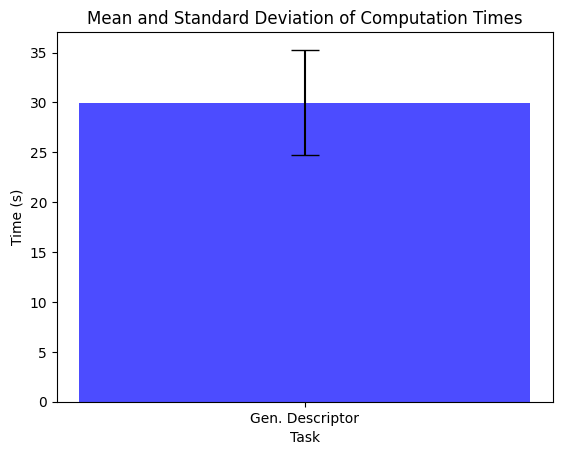

In [38]:
# Sample computation times (replace this with your data)
computation_times = [10.2, 9.5, 11.0, 10.8, 9.2, 11.5, 10.0, 9.7]

desc_times = time_data[:,0]
query_times = time_data[:,1]
update_times = time_data[:,2]
print(desc_times.shape)

desc_mean = np.mean(desc_times)
query_mean = np.mean(query_times)
update_mean = np.mean(update_times)
desc_std = np.std(desc_times)
query_std = np.std(query_times)
update_std = np.std(update_times)

# # Calculate the mean and standard deviation
# mean_time = np.mean(computation_times)
# std_dev = np.std(computation_times)

# # Data for plotting
labels = ['Gen. Descriptor']
values = [desc_mean]
error = [desc_std]

# # Create a bar graph with error bars
plt.bar(labels, values, yerr=error, color='blue', alpha=0.7, capsize=10)

# # Add labels and title
plt.xlabel('Task')
plt.ylabel('Time (s)')
plt.title('Mean and Standard Deviation of Computation Times')

# # Show the plot
plt.show()